# **Predicting Charged-Off Loans with LendingClub Data**

# Table of Contents
1. [Introduction](#intro)
2. [Import the data](#importdata)
3. [Target Variable](#targetvariable)
4. [Feature Selection I: EDA](#featureselection)  
    4.1 [Drop features missing too much data](#missing_data)  
    4.2 [Remove "cheat" data](#cheat_data)  
    4.3 [Inspect the remaining features one by one](#inspect)  
5. [Feature Section II: (Linear) correlation between (numerical) features](#corr)   
    5.1 [Convert target variable to 0/1 indicator](#converttarget)   
    5.2 [K-S test](#kstest)   
    5.3 [Pearson Correlation](#pearson)   
6. [Feature Engineering](#featureeng)  
    6.1 [Dummy variables](#dummies)  
    6.2 [Train/Test data split](#split)  
    6.3 [Imputing missing values](#imputing)  
    6.4 [Feature Scaling](#scaling)  
    6.5 [PCA visualization of the train data](#pca)   
    6.6 [Linear dependence of Charged-Off](#pearson2)
7. [Modeling](#modeling)  
    7.1 [Logistic Regression with SGD](#logreg)  
    7.2 [Random Forest](#rf)   
    7.3 [KNN](#knn)  
    7.4 [Hyperparameter tuning on the best model](#hyper)  
    7.5 [Evaluate the best model on the testing set](#evaluate)  
8. [Further understanding the model](#understanding)
9. [Conclusion](#conclusion)

Additionally: 
[MyGitHub](https://github.com/yanxiali)

In [1]:
# Imports
import os
import pandas as pd
from pandas import Series, DataFrame
import pandas_profiling

pd.set_option('display.max_rows', None,'display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, cross_validate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer

from scipy.stats import ks_2samp
from treeinterpreter import treeinterpreter as ti

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn import cross_validation
from sklearn import metrics

"""
from sklearn import metrics
from sklearn import linear_model

from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import preprocessing
"""

# ignore Deprecation Warning
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning,RuntimeWarning) 
warnings.filterwarnings("ignore") 

#plt.style.use('fivethirtyeight') # Good looking plots
pd.set_option('display.max_columns', None) # Display any number of columns


/Users/yanxia/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Introduction
<a id="intro"></a>
The objective is to use the loan data to build a model that can predict the loan status (whether or not a loan will be fully paid or charged off) and interpret the results to find the factors which affect the result.  

We want to develop a model that is **accurate** and **interpretable**.

This problem is a binary classification as I have only two classes to predict.

## 2. Data
<a id="importdata"></a>

In this project, I will work with the publicly available Lending Club data on [Kaggle](https://www.kaggle.com/wordsforthewise/lending-club). 
The dataset is 1.8+ GB of size, including 1.6 millions of loans from 2007 to 2017Q, each of which has 150 associated features. 

In [2]:
df = pd.read_csv('../input/accepted_2007_to_2017Q3.csv.gz',compression='gzip',low_memory=True)
#df = pd.read_csv('../input/accepted_2017.csv.gz',compression='gzip',low_memory=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646801 entries, 0 to 1646800
Columns: 150 entries, id to settlement_term
dtypes: float64(113), object(37)
memory usage: 1.8+ GB


In [4]:
df.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
847812,7341841,NaN,18825.0,18825.0,18825.0,60 months,17.76,475.58,D,D1,fujirebio Diagnostics,6 years,MORTGAGE,43000.0,Verified,Oct-2013,Fully Paid,n,NaN,credit_card,debt,194xx,PA,5.11,0.0,Feb-1987,660.0,664.0,2.0,NaN,74.0,9.0,2.0,4859.0,35.2,23.0,f,0.00,0.00,27536.843240,27536.84,18825.00,8711.84,0.0,0.0,0.0,Apr-2017,8038.06,NaN,Oct-2017,694.0,690.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,171872.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13800.0,NaN,NaN,NaN,4.0,21484.0,5073.0,36.6,0.0,0.0,111.0,324.0,3.0,3.0,4.0,30.0,NaN,1.0,NaN,0.0,3.0,7.0,3.0,5.0,4.0,8.0,15.0,7.0,9.0,0.0,0.0,0.0,3.0,100.0,33.3,2.0,0.0,183315.0,4859.0,8000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
36130,32999867,NaN,10000.0,10000.0,10000.0,36 months,12.49,334.49,B,B5,NaN,NaN,RENT,46419.0,Verified,Oct-2014,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,641xx,MO,24.87,0.0,May-1998,665.0,669.0,0.0,27.0,NaN,8.0,0.0,5871.0,50.6,23.0,w,0.00,0.00,12038.341597,12038.34,10000.00,2038.34,0.0,0.0,0.0,Dec-2017,0.11,NaN,Dec-2017,689.0,685.0,0.0,27.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,33397.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11600.0,NaN,NaN,NaN,2.0,4175.0,26.0,98.9,0.0,0.0,164.0,197.0,27.0,11.0,4.0,89.0,NaN,11.0,NaN,1.0,1.0,6.0,1.0,3.0,8.0,6.0,10.0,6.0,8.0,0.0,0.0,0.0,1.0,95.7,100.0,0.0,0.0,47872.0,33397.0,2300.0,36272.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
839208,7265177

The dataset has numerical, categorical and missing values. Because there are so many features (150+), i will start the data engineering with dropping unnecessary features and then deal with the remaining features more in detail. 

## 3. Target Variable
<a id="targetvariable"></a>

We are trying to predict the loan_status column. Let's check the value distributions in this column first

In [5]:
df['loan_status'].value_counts()

Current                                                788950
Fully Paid                                             646902
Charged Off                                            168084
Late (31-120 days)                                      23763
In Grace Period                                         10474
Late (16-30 days)                                        5786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    70
Name: loan_status, dtype: int64

We will try to distinguish 2 cases: loans being fully paid or charged off, assuming that they both meet the credit policy. 
We will only keep the rows with loan_status being "fully paid" or "charged off". 

In [6]:
df = df.loc[df['loan_status'].isin(['Fully Paid','Charged Off'])]

In [7]:
df['loan_status'].value_counts(normalize=False, dropna=False)

Fully Paid     646902
Charged Off    168084
Name: loan_status, dtype: int64

In [8]:
df['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.793758
Charged Off    0.206242
Name: loan_status, dtype: float64

About 80% (~647k) of the loans have been fully paid, and 21% (168k) have been charged off. Unbalanced data. I will try to handle this unbalance in the cross validation and need to pick appropriate metrics.

## 4. Feature Selection
<a id="featureselection"></a>

The raw data has 150 features, but not all of them are useful. 
Definitions of the columns are given in the Lending Club "Data Dictionary" [available here](https://www.lendingclub.com/info/download-data.action).

We will drop the features with the following criteria:
- More than 50% of the data is missing
- The feature would not have been available at the time of the loan application ("issue_d"). 

We will also address the following:
- convert strings to numerical values
- drop superfluous attributes
- highly correlated predictors
- zero (or nearly zero) variance predictors

### 4.1 Drop features missing too much data
<a id="missing_data"></a>

In [9]:
# Define a function to visulize the features with missing values, and % of total values, & datatype
def missing_values_table(df):
     # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_type = df.dtypes
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_type], axis=1)
        
     # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'type'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [10]:
missing_values_table(df)

Your selected dataframe has 150 columns.
There are 104 columns that have missing values.


,Missing Values,% of Total Values,type
member_id,814986,100.0,float64
next_pymnt_d,814986,100.0,object
orig_projected_additional_accrued_interest,814885,100.0,float64
sec_app_mths_since_last_major_derog,814683,100.0,float64
hardship_length,814395,99.9,float64
hardship_type,814395,99.9,object
hardship_reason,814395,99.9,object
hardship_status,814395,99.9,object
deferral_term,814395,99.9,float64
hardship_amount,814395,99.9,float64


From this table, we can see that there is a huge gap between features missing some data (~15% and below) and those missing lots of data (up to 100%!). I chose 49% as the cutoff.

In [11]:
missing_frac = df.isnull().mean()
drop_list = sorted(missing_frac[missing_frac > 0.48].index)

In [12]:
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

In [13]:
len(drop_list)

58

In [14]:
def drop_cols(cols):
    df.drop(labels=cols, axis=1, inplace=True)

In [15]:
drop_cols(drop_list)

In [16]:
df.shape

(814986, 92)

### 4.2 Remove "cheat" data
<a id="cheat_data"></a>

The goal of this project is to predict whether a loan will be paid off BEFORE making the decision to lend the loan. Therefore, I would like to remove the features that were unavailable before lending a loan.  

In [17]:
print(sorted(df.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

After checking the definition of these features, I will drop the ones that would have not been available before a load was lend. 

In [18]:
#drop_list = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']
drop_list = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim']


In [19]:
len(drop_list)

58

In [20]:
drop_cols(drop_list)

In [21]:
print(sorted(df.columns))

['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc', 'open_acc', 'policy_code', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']


In [22]:
len(df.columns)

34

### 4.3 Inspect the remaining features one by one
<a id="inspect"></a>

Now we are left with reasonable number of features (34),I will screen each feature and decide if a feature should be dropped. I will do an EDA for each feature. After pre-processing each feature, I will do some overall statistical tests for all the features, their correlations, etc.
The tasks involved include:
- Missing data and outliers
- Cleaning & Formatting: 
    - Histogram of the to-be-checked feature & its relation to the target variable.  
- Transformation of features
- choose the most relevant features in the data

In [23]:
df.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,policy_code,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mort_acc,pub_rec_bankruptcies
count,814986.000000,814986.000000,814986.000000,8.149860e+05,814950.000000,814986.000000,814986.000000,814986.000000,814986.000000,8.149860e+05,814496.000000,814986.000000,814986.0,725427.000000,747458.000000,767705.000000,814289.000000
mean,14315.458210,13.490993,436.749624,7.523039e+04,17.867719,695.603151,699.603264,11.521099,0.205734,1.606864e+04,53.031137,25.421359,1.0,125.926232,180.843182,1.758707,0.132007
std,8499.799241,4.618486,255.732093,6.524373e+04,8.856477,31.352251,31.352791,5.325064,0.584933,2.160500e+04,24.320981,11.970502,0.0,51.554620,92.192939,2.081730,0.375188
min,500.000000,5.320000,4.930000,0.000000e+00,-1.000000,625.000000,629.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,1.0,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,9.990000,251.400000,4.500000e+04,11.640000,670.000000,674.000000,8.000000,0.000000,6.014000e+03,35.000000,17.000000,1.0,98.000000,117.000000,0.000000,0.000000
50%,12000.000000,13.110000,377.040000,6.500000e+04,17.360000,690.000000,694.000000,11.000000,0.000000,1.118500e+04,53.700000,24.000000,1.0,129.000000,164.000000,1.000000,0.000000
75%,20000.000000,16.290000,576.290000,9.000000e+04,23.630000,710.000000,714.000000,14.000000,0.000000,1.972300e+04,71.900000,32.000000,1.0,152.000000,228.000000,3.000000,0.000000
max,40000.000000,30.990000,1714.540000,9.550000e+06,999.000000,845.000000,850.000000,90.000000,86.000000,2.568995e+06,892.300000,176.000000,1.0,724.000000,842.000000,51.000000,12.000000


In [24]:
# make general plots to examine each feature
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,3))
    # plot1: counts distribution of the variable
    
    if continuous:  
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

          
    # plot2: bar plot of the variable grouped by loan_status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        Charged_Off_rates = df.groupby(col_name)['loan_status'].value_counts(normalize=True)[:,'Charged Off']
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged Off')
        ax2.set_title('Charged Off Rate by ' + full_name)
        ax2.set_xlabel(full_name)
    
    # plot3: kde plot of the variable gropued by loan_status
    if continuous:  
        facet = sns.FacetGrid(df, hue = 'loan_status', size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        #facet.set(xlim=(df[col_name].min(), df[col_name].max()))
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='loan_status', data=df, order=sorted(df[col_name].unique()) )
     
    plt.tight_layout()


### issue_d
Data Dictionary: "The month which the loan was funded.

Because we are only using the variables that are available before the loan was funded to make predictions, issue_d will not be included in modeling. This feature is kept here for train/test sample split, after which this feature will be dropped. 

### id
Data Dictionary: "A unique assigned ID for the loan listing."

In [25]:
df['id'].sample(5)

27595       34372545
1335528     78299211
604710      44825912
891278       4915267
995388     103567392
Name: id, dtype: object

In [26]:
len(df['id'].unique())

814986

"id" is a unique index. It's not useful as a categorical variable (so many unique values), nor as a numerical variable (a wild range of its values). Therefore I will drop this feature. 

In [27]:
drop_cols('id')

### loan_amnt
Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [28]:
df['loan_amnt'].describe()

count    814986.000000
mean      14315.458210
std        8499.799241
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

"loan_amnt" ranges from \$0.5 k to \$40 k, with a median of 12k. 

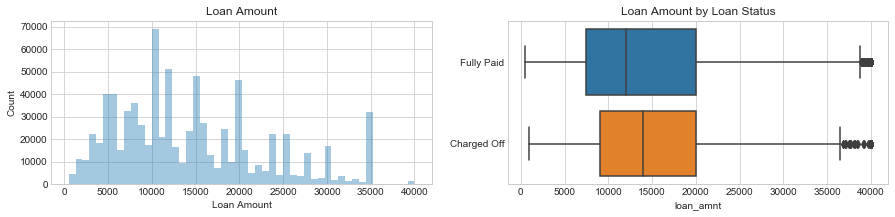

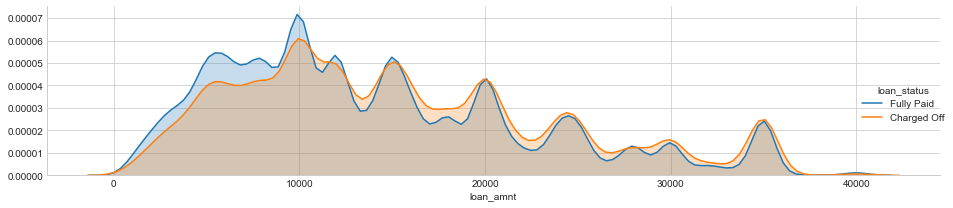

In [29]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

"Charged off" loans seem to have higher loan amount. I will further examine the statistical difference in the later analysis.

### term
Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

In [30]:
df['term'].sample(5)

1442189     36 months
1088818     36 months
982341      36 months
140603      60 months
1521384     60 months
Name: term, dtype: object

In [31]:
df['term'].value_counts(dropna=False)

 36 months    618460
 60 months    196526
Name: term, dtype: int64

In [32]:
df['term'] = df['term'].apply(lambda s: np.int8(s.split()[0]))

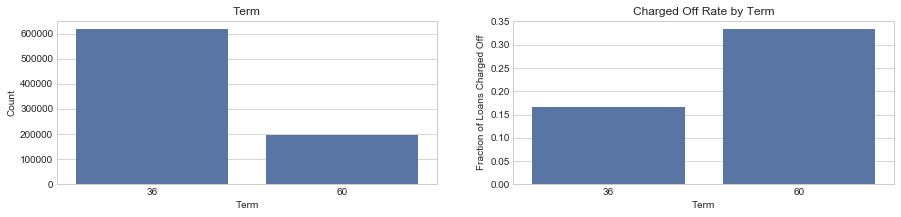

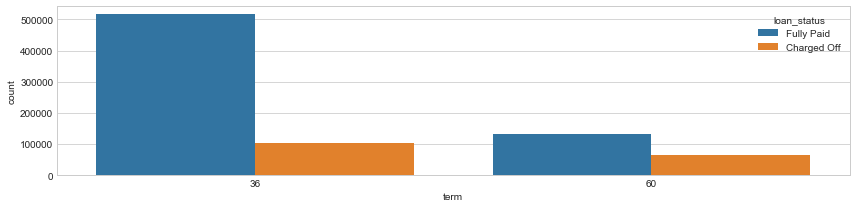

In [33]:
plot_var('term', 'Term', continuous=False)

In [34]:
df['term'].value_counts(normalize=True)

36    0.75886
60    0.24114
Name: term, dtype: float64

About 76% of the loans are 36 months and the rest are 60 months. The latter tends to have lower fraction of being fully paid.

Compare the charge-off rate by loan period

In [35]:
df.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.165710
60    0.333793
Name: loan_status, dtype: float64

17% of the 36-month loans are charge off, while 33% of the 60-month are charged off. Longer term leads to higher charged off? This feature should be useful in modeling.

### int_rate
Data Dictionary: "Interest Rate on the loan."

In [36]:
df['int_rate'].describe()

count    814986.000000
mean         13.490993
std           4.618486
min           5.320000
25%           9.990000
50%          13.110000
75%          16.290000
max          30.990000
Name: int_rate, dtype: float64

The interest rage ranges from 5% to 31%, with a median at 13%. 

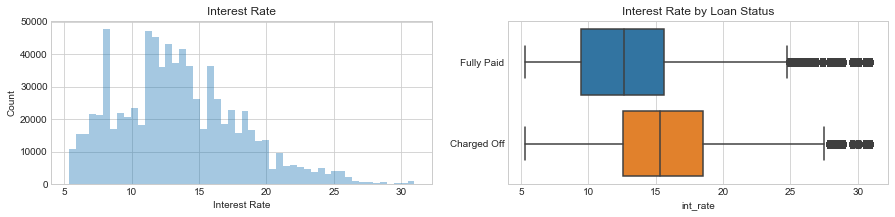

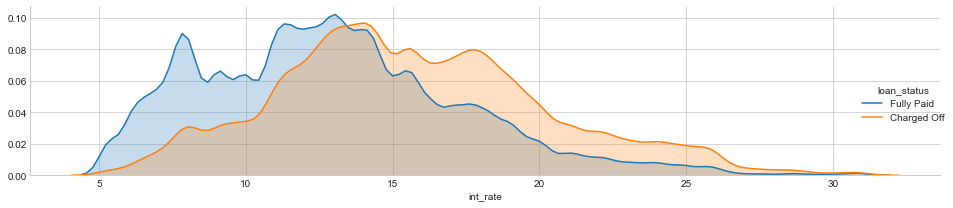

In [37]:
plot_var('int_rate', 'Interest Rate', continuous=True)

The higher the interest rate is, the more likely for being charged off. 
There are some outliers in the Fully Paid dataset. Let's take a look at them, as outliers may distort ML analysis. 

### Outliers
- outliers can be exactly what we want to learn about, e.g., anomaly detection. 
- In this project, however, outliers may distort the picture of the data in both statistical analysis and visualization. 
- Below, I use the modified Z-score method and the IQR method. Note that the variable must be continuous, not categorical, for any of these functions to make sense.

drop_list = df.select_dtypes(exclude=['object']).columns

In [38]:
def outliers_modified_z_score(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices corresponding to the observations containing more than n outliers according to the modified z-score Method
    """
    threshold = 3.5
    outlier_indices = []
    for col in features:
        median_y = np.median(dataframe[col])
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in dataframe[col]])
        modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in dataframe[col]]
        outlier_list_col = dataframe[np.abs(modified_z_scores) > threshold].index
       # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers

#Outliers_to_drop_z_score = outliers_modified_z_score(df,2,['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti','fico_range_high', 'pub_rec', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc','earliest_cr_line_'])

In [39]:
def outliers_iqr(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    for col in features:
        # 1st quartile (25%) & # 3rd quartile (75%)
        quartile_1, quartile_3 = np.percentile(dataframe[col], [25,75])
        #quartile_3 = np.percentile(dataframe[col], 75)
      
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        # Determine a list of indices of outliers for feature col
        outlier_list_col = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)].index
       # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers

In [40]:
""" 
# As our final exploratory plot, we will create pairs plot to visualize relationships between multiple pairs of variables as well as distributions of single variables.

# Extract the columns to  plot
plot_data = df[float_list]

# Replace the inf with nan
#plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Rename columns 
#plot_data = plot_data.rename(columns = {'Site EUI (kBtu/ft²)': 'Site EUI', 'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI', 'log_Total GHG Emissions (Metric Tons CO2e)': 'log GHG Emissions'})

# Drop na values
plot_data = plot_data.dropna()

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)
# Create the pairgrid object
#grid = sns.PairGrid(data = plot_data, size = 3)

# Upper is a scatter plot
grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)

# Diagonal is a histogram
grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')

# Bottom is correlation and density plot
grid.map_lower(corr_func);
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)

# Title for entire plot
plt.suptitle('Pairs Plot of Energy Data', size = 36, y = 1.02);
"""

' \n# As our final exploratory plot, we will create pairs plot to visualize relationships between multiple pairs of variables as well as distributions of single variables.\n\n# Extract the columns to  plot\nplot_data = df[float_list]\n\n# Replace the inf with nan\n#plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})\n\n# Rename columns \n#plot_data = plot_data.rename(columns = {\'Site EUI (kBtu/ft²)\': \'Site EUI\', \'Weather Normalized Source EUI (kBtu/ft²)\': \'Weather Norm EUI\', \'log_Total GHG Emissions (Metric Tons CO2e)\': \'log GHG Emissions\'})\n\n# Drop na values\nplot_data = plot_data.dropna()\n\n# Function to calculate correlation coefficient between two columns\ndef corr_func(x, y, **kwargs):\n    r = np.corrcoef(x, y)[0][1]\n    ax = plt.gca()\n    ax.annotate("r = {:.2f}".format(r),\n                xy=(.2, .8), xycoords=ax.transAxes,\n                size = 20)\n# Create the pairgrid object\n#grid = sns.PairGrid(data = plot_data, size = 3)\n\n# Upper is a s

In [41]:
df.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,15.736335,4.625755,5.32,12.59,15.31,18.55,30.99
Fully Paid,646902.0,12.907587,4.434262,5.32,9.49,12.68,15.61,30.99


Any values > 75% percentile (18.5 for "charged off", 15.61 for "Fully Paid") are defined as outliers. 

In [42]:
#df.groupby('loan_status')['int_rate'].value_counts()['Fully Paid'].sort_index()

In [43]:
df.loc[(df.int_rate > 15.61) & (df.loan_status == 'Fully Paid')].shape[0]

150885

In [44]:
(df.loc[(df.int_rate > 15.61) & (df.loan_status == 'Fully Paid')].shape[0])/df['loan_status'].value_counts(normalize=False, dropna=False)[0]

0.2332424385764768

In [45]:
df.loc[(df.int_rate >18.55) & (df.loan_status == 'Charged Off')].shape[0]/df['loan_status'].value_counts(normalize=False, dropna=False)[1]

0.24427072178196615

The percentage of outliers is roughly the same for the Fully Paid/Charged off data, ~23%. A bit too much to be dropped. I will keep these outliers for now.

### installment
Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [46]:
df['installment'].describe()

count    814986.000000
mean        436.749624
std         255.732093
min           4.930000
25%         251.400000
50%         377.040000
75%         576.290000
max        1714.540000
Name: installment, dtype: float64

Installments range from \$5  to \$1715, with a median at \$377. 

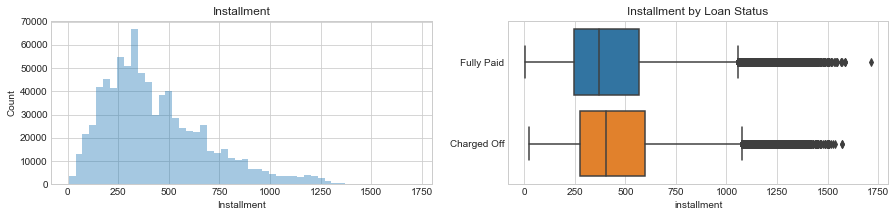

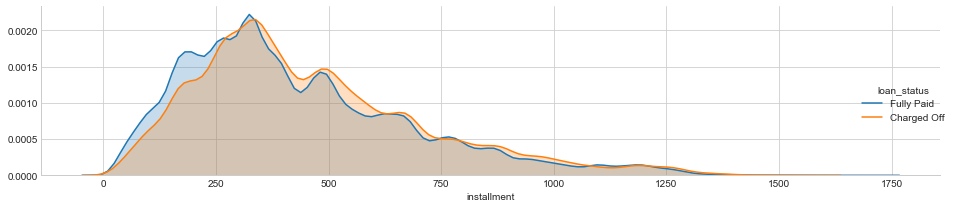

In [47]:
plot_var('installment', 'Installment', continuous=True)

Charged-off loans tend to have higher installments but the difference of the mean values is very small (460 vs 431). Later, I will do a KS test to see if there are any statistical difference of "installment" between Fully Paid/charged off. 

In [48]:
df.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,459.973673,255.309267,21.62,276.14,402.39,595.87,1569.11
Fully Paid,646902.0,430.715339,255.496761,4.93,244.76,370.92,569.72,1714.54


### grade, sub_grade
Data Dictionary for grade: "assigned loan grade."
Data Dictionary for sub_grade: "LC assigned loan subgrade."

What are the possible values of grade and sub_grade?

In [49]:
sorted(df['grade'].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [50]:
print(sorted(df['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The "grade" is included in the "sub_grade" column, so it could be dropped.

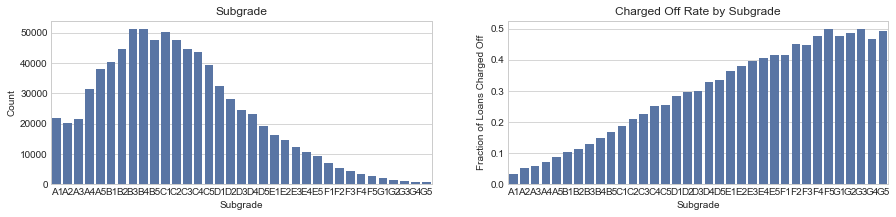

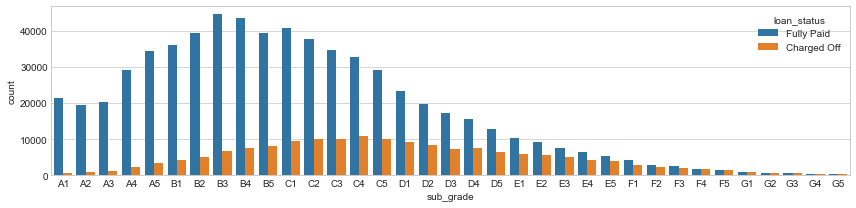

In [51]:
plot_var('sub_grade','Subgrade',continuous=False)

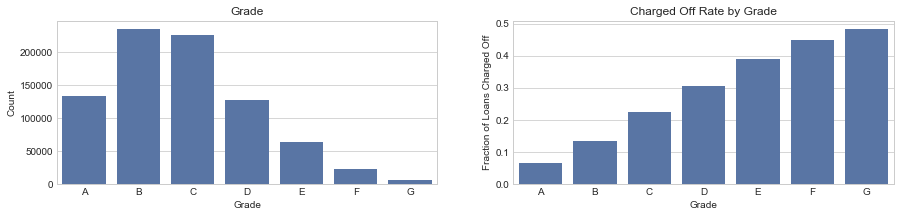

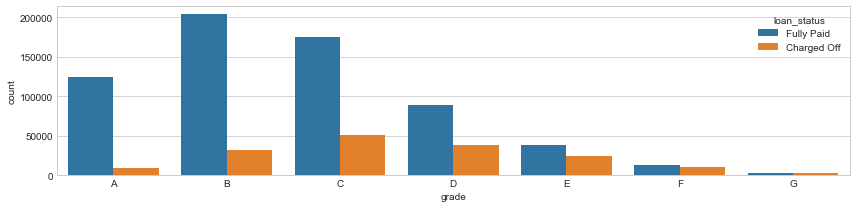

In [52]:
plot_var('grade','Grade',continuous=False)

There is a trend of higher fraction of loans Charged off as the grade going from A to G, with some small variations among subgrades. 

In [53]:
#df.drop(labels='grade',axis=1,inplace=True)
drop_cols('grade')

### emp_title
Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [54]:
df['emp_title'].describe()

count      766415
unique     280473
top       Teacher
freq        11351
Name: emp_title, dtype: object

There are too many unique titles for this feature to be useful, so we drop this feature. 

In [55]:
df['emp_title'].sample(5)

984197                 Billeo
88917                  Driver
197593                    NaN
1048907    RURAL MAIL CARRIER
336144                 driver
Name: emp_title, dtype: object

In [56]:
drop_cols('emp_title')

### emp_length
Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [57]:
df['emp_length'].value_counts(dropna=False).sort_index()

1 year        53411
10+ years    264873
2 years       73493
3 years       64999
4 years       48752
5 years       52149
6 years       40290
7 years       39407
8 years       38887
9 years       31900
< 1 year      64572
NaN           42253
Name: emp_length, dtype: int64

There are 42k loans without the information on emp_length. Convert this feature to integers. 

In [58]:
df['emp_length'].replace('10+ years', '10 years', inplace=True)

In [59]:
df['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [60]:
df['emp_length'].value_counts(dropna=False).sort_index()

0 years      64572
1 year       53411
10 years    264873
2 years      73493
3 years      64999
4 years      48752
5 years      52149
6 years      40290
7 years      39407
8 years      38887
9 years      31900
NaN          42253
Name: emp_length, dtype: int64

In [61]:
df.emp_length.map( lambda x: str(x).split()[0]).value_counts(dropna=True).sort_index()

0       64572
1       53411
10     264873
2       73493
3       64999
4       48752
5       52149
6       40290
7       39407
8       38887
9       31900
nan     42253
Name: emp_length, dtype: int64

In [62]:
df['emp_length'] = df.emp_length.map( lambda x: float(str(x).split()[0]))

In [63]:
df['emp_length'].sample(5)

293916    10.0
798787     6.0
313216    10.0
346149    10.0
614188     3.0
Name: emp_length, dtype: float64

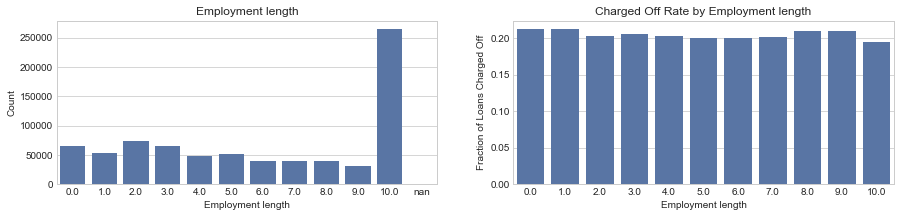

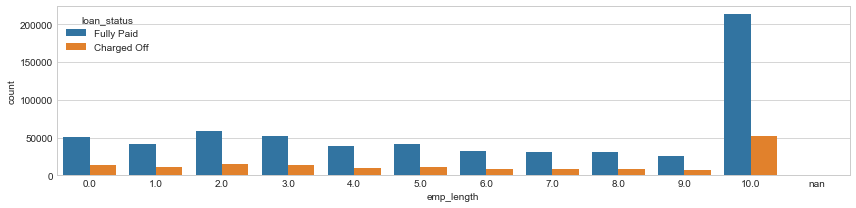

In [64]:
plot_var('emp_length', 'Employment length', continuous=False)

One third of the loans go to the people with longer than 10 years of employments. However, the fully paid rate seems not quite related to this feature. Again, this will be further examined in a statistical test at the end. 

### home_ownership
Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [65]:
df['home_ownership'].value_counts()

MORTGAGE    406866
RENT        325071
OWN          82765
OTHER          144
ANY             94
NONE            46
Name: home_ownership, dtype: int64

Replace "ANY" & "None" with "OTHER". 

In [66]:
df['home_ownership'].replace(['NONE','ANY'],'OTHER', inplace=True)

In [67]:
df['home_ownership'].value_counts()

MORTGAGE    406866
RENT        325071
OWN          82765
OTHER          284
Name: home_ownership, dtype: int64

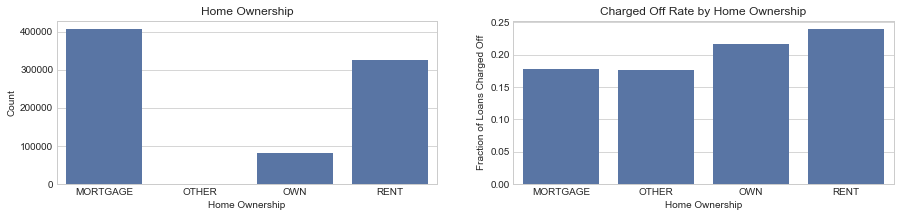

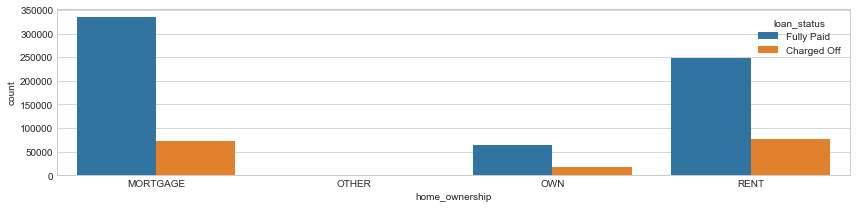

In [68]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

In [69]:
df.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.177808
OTHER       0.176056
OWN         0.215804
RENT        0.239422
Name: loan_status, dtype: float64

There appear to be small differences in charge-off rates by home ownership status. Mortgage & OTHER has slightly less probability of Charged-Off. Because of the large numbers of observations in each category, these differences might be statistically significant.

### annual_inc
Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [70]:
df['annual_inc'].describe()

count    8.149860e+05
mean     7.523039e+04
std      6.524373e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.550000e+06
Name: annual_inc, dtype: float64

Annual income ranges from \$0 to \$8M, with a median at \$65k, which doubles the national median individual income in the US (\$40k for males and \$25k for females). Due to the large range of variation, we log-transform the values.

In [71]:
df['annual_inc'] = df['annual_inc'].apply(lambda x:np.log10(x+1))

In [72]:
df['annual_inc'].describe()

count    814986.000000
mean          4.810836
std           0.231893
min           0.000000
25%           4.653222
50%           4.812920
75%           4.954247
max           6.980003
Name: annual_inc, dtype: float64

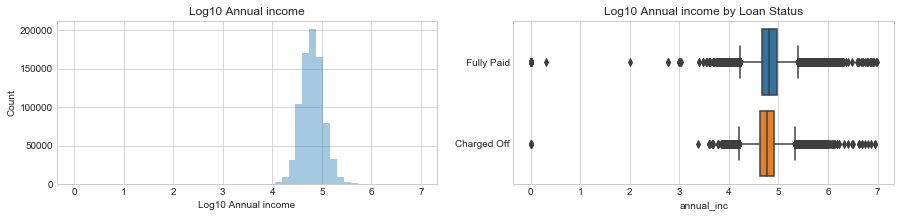

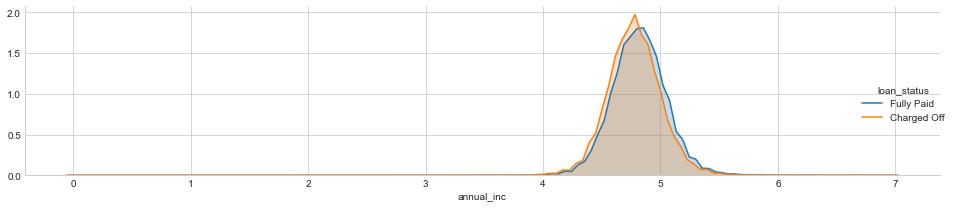

In [73]:
plot_var('annual_inc', 'Log10 Annual income', continuous=True)

Let's look closer of the difference here

In [74]:
df.groupby('loan_status')['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,4.777072,0.227015,0.0,4.632467,4.778158,4.915096,6.949393
Fully Paid,646902.0,4.819608,0.232342,0.0,4.672107,4.812920,4.963793,6.980003


For both cases, there are quite a few outliers (in the lower end). 

### verication_status
Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

In [75]:
df['verification_status'].value_counts()

Source Verified    293897
Verified           269895
Not Verified       251194
Name: verification_status, dtype: int64

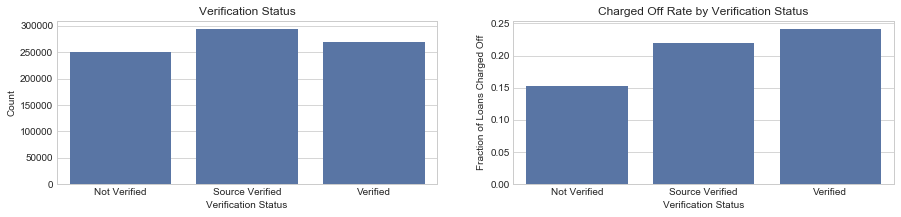

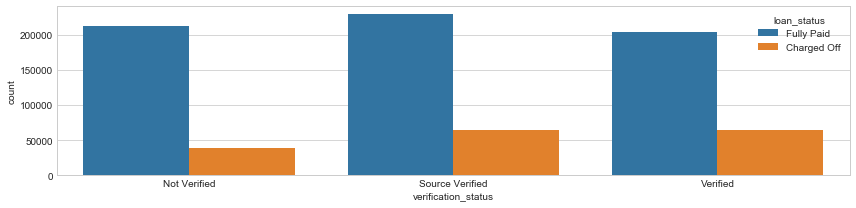

In [76]:
plot_var('verification_status', 'Verification Status', continuous=False)

Surprisingly, verified loans have higher chance of being charged-Off. I would guess the opposite way.

### purpose
Data Dictionary: "A category provided by the borrower for the loan request."

In [77]:
df['purpose'].value_counts()

debt_consolidation    481652
credit_card           175123
home_improvement       50793
other                  43900
major_purchase         17463
small_business         10214
car                     8936
medical                 8772
moving                  5725
vacation                5116
house                   4095
wedding                 2272
renewable_energy         599
educational              326
Name: purpose, dtype: int64

Now let's check the charged-off rates of purposes.

In [78]:
df.groupby('purpose')['loan_status'].value_counts(normalize=True)[:,'Charged Off'].sort_values(ascending=False)

purpose
small_business        0.302428
renewable_energy      0.247078
moving                0.242969
medical               0.229366
debt_consolidation    0.217398
other                 0.216970
house                 0.214652
vacation              0.198788
major_purchase        0.183245
home_improvement      0.181383
credit_card           0.178412
educational           0.171779
car                   0.148053
wedding               0.121919
Name: loan_status, dtype: float64

We see that, 30% of the loans for small_business are charged off, but only 12% of wedding are charged Off.

### title
Data Dictionary: "The loan title provided by the borrower."

In [79]:
df['title'].describe()

count                 807068
unique                 60298
top       Debt consolidation
freq                  371874
Name: title, dtype: object

In [80]:
df['title'].value_counts().head(10)

Debt consolidation         371874
Credit card refinancing    133334
Home improvement            39171
Other                       33265
Debt Consolidation          15059
Major purchase              12311
Medical expenses             6908
Business                     6666
Car financing                5667
Consolidation                5090
Name: title, dtype: int64

There are 12 unique purposes in the dataset, and from the top 10 titles, it seems that this information is covered in the "purpose". So we drop this column. 

In [81]:
drop_cols('title')

### zip_code, addr_stat
Data Dictionary for zip_code: "The first 3 numbers of the zip code provided by the borrower in the loan application."  
Data Dictionary for addr_state: "The state provided by the borrower in the loan application."  

In [82]:
df['zip_code'].describe()

count     814986
unique       925
top        945xx
freq        9517
Name: zip_code, dtype: object

In [83]:
df['addr_state'].describe()

count     814986
unique        51
top           CA
freq      124204
Name: addr_state, dtype: object

There are many unique "zip_code" values, and the zip_code info should be equivalent to "addr_stat". Therefore we drop the "zip_code". 

In [84]:
drop_cols('zip_code')

In [85]:
df.groupby('addr_state')['loan_status'].value_counts(normalize=True)[:,'Charged Off'].sort_values(ascending=False)

addr_state
MS    0.275619
NE    0.267946
OK    0.248252
AL    0.247650
AR    0.243154
LA    0.237900
ND    0.237232
NV    0.234202
TN    0.230479
IN    0.228179
NY    0.227045
SD    0.225787
NM    0.225694
OH    0.225400
FL    0.222007
MO    0.219400
KY    0.216353
NJ    0.216208
NC    0.215282
MD    0.214845
PA    0.214776
MN    0.210363
MI    0.208880
VA    0.207942
DE    0.206575
HI    0.204535
AK    0.204141
TX    0.202286
AZ    0.199321
CA    0.198303
RI    0.194009
ID    0.193487
IL    0.193302
MA    0.192974
GA    0.191224
CT    0.183810
WV    0.182457
UT    0.179049
WY    0.178142
MT    0.177759
WI    0.175315
SC    0.172705
KS    0.171004
WA    0.166538
CO    0.158083
OR    0.152827
VT    0.149225
IA    0.142857
NH    0.142554
ME    0.136564
DC    0.130378
Name: loan_status, dtype: float64

MS has the highest fraction of Charged Off (0.28), whereas DC has the lowest fraction at 0.13. 

### dti
Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."

In [86]:
df['dti'].describe()

count    814950.000000
mean         17.867719
std           8.856477
min          -1.000000
25%          11.640000
50%          17.360000
75%          23.630000
max         999.000000
Name: dti, dtype: float64

The values of -1 or 999 are probably outliers. Let's look at its histogram .

Text(0.5,1,'DTI by loan status')

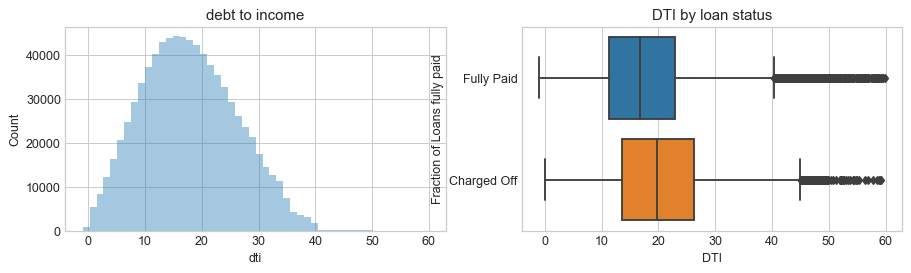

In [87]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.distplot(df.loc[df['dti'].notnull() & (df['dti'] < 60), 'dti'], kde=False, ax=ax1)
ax1.set_xlabel('dti')
ax1.set_ylabel('Count')
ax1.set_title('debt to income')
sns.boxplot(x=df.loc[df['dti'].notnull() & (df['dti'] < 60), 'dti'], y='loan_status', data=df, ax=ax2)
ax2.set_xlabel('DTI')
ax2.set_ylabel('Fraction of Loans fully paid')
ax2.set_title('Fully paid rate by debt to income')
ax2.set_title('DTI by loan status')

In [88]:
(df['dti'] > 40).sum() / (df['dti']).sum()

0.0001017766442811112

In [89]:
(df['dti'] > 40).sum()

1482

Very few (0.01%) outliers with dti > 60. 
From the figure it seems that the Charged Off loans have higher DTI. Let's check. 

In [90]:
df.groupby('loan_status')['dti'].median()

loan_status
Charged Off    19.77
Fully Paid     16.77
Name: dti, dtype: float64

It's clear that borrowers who have higher DTI are more likely to be charged off 

### earliest_cr_line
Data Dictionary: "The month the borrower's earliest reported credit line was opened."

Rather than converting it to a date, I will use a scalar to describe the length of time since the first line of credit. If all other variables are held equal, the longer you have had lines of credit the better. 

In [91]:
df['earliest_cr_line'].sample(5)

194774     Feb-1999
859839     Feb-2007
42415      Sep-1999
1487059    Dec-1993
250915     Feb-2006
Name: earliest_cr_line, dtype: object

In [92]:
df['earliest_cr_line'].describe()

count       814986
unique         712
top       Aug-2001
freq          6024
Name: earliest_cr_line, dtype: object

In [93]:
df['earliest_cr_line'].isnull().any()

False

In [94]:
from datetime import datetime

df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line)

dttoday = datetime.now().strftime('%Y-%m-%d')
df.earliest_cr_line = df.earliest_cr_line.apply(lambda x:(np.timedelta64((x - pd.Timestamp(dttoday)),'D').astype(int))/-365)

df.earliest_cr_line.shape

(814986,)

In [95]:
df.earliest_cr_line.sample(5)

834954     23.783562
1062327    10.775342
958945     12.690411
256108     34.791781
437955     25.783562
Name: earliest_cr_line, dtype: float64

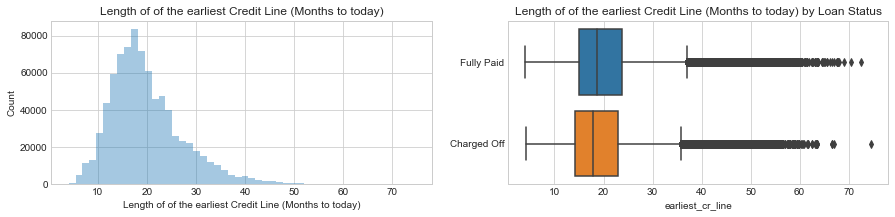

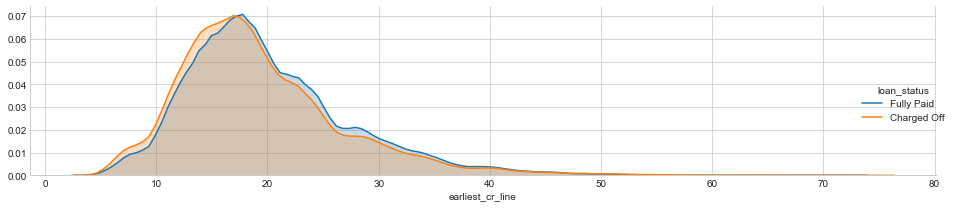

In [96]:
plot_var('earliest_cr_line', 'Length of of the earliest Credit Line (Months to today)', continuous=True)

Borrowers who charged off have opened their first credit line more recently, although their medians are almost the same.

In [97]:
df.groupby('loan_status')['earliest_cr_line'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,19.266402,7.399904,4.189041,14.194521,17.860274,22.865753,74.567123
Fully Paid,646902.0,20.039715,7.382157,4.021918,14.945205,18.695890,23.783562,72.564384


### fico_range_low, fico_range_high
Data Dictionary for fico_range_low: "The lower boundary range the borrower’s FICO at loan origination belongs to."  
Data Dictionary for fico_range_high: "The upper boundary range the borrower’s FICO at loan origination belongs to."


In [98]:
df[['fico_range_low','fico_range_high']].describe()

,fico_range_low,fico_range_high
count,814986.000000,814986.000000
mean,695.603151,699.603264
std,31.352251,31.352791
min,625.000000,629.000000
25%,670.000000,674.000000
50%,690.000000,694.000000
75%,710.000000,714.000000
max,845.000000,850.000000


Check the correlation between the two:

In [99]:
df[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


These two are highly correlated, therefore we only need to keep one. We create a new feature, "fico_score" which is the mean value of the "fico_range_low" and "fico_range_high"

In [100]:
df['fico_score'] = (df['fico_range_low'] + df['fico_range_high'])/2.

In [101]:
#df.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)
drop_cols(['fico_range_high','fico_range_low'])

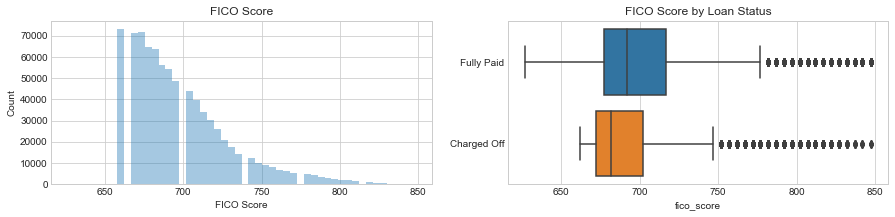

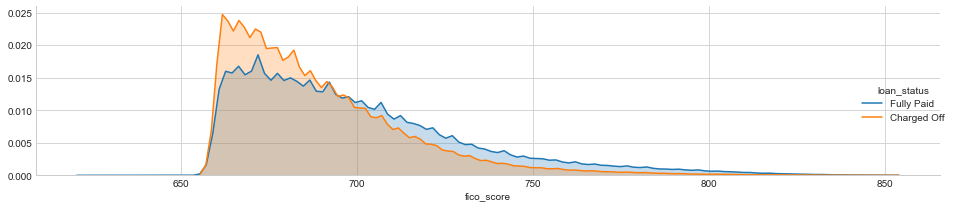

In [102]:
plot_var('fico_score', 'FICO Score', continuous=True)

There is noticeable difference in FICO scores between fully paid and charged-off loans.

A side note, what are the missing values in the specific FICO scores (i.e., ~620, 700, 730)??

As I know that FICO score is a very important feature, I would like to check the correlations between FICO score, int_rate and the term, 3 of the most important features that are difference between "Charged-off" and "fully paid" loans from previous EDA.

In [103]:
df[['fico_score','int_rate','term']].corr()

,fico_score,int_rate,term
fico_score,1.000000,-0.425425,-0.005257
int_rate,-0.425425,1.000000,0.426839
term,-0.005257,0.426839,1.000000


It seems that the higher the fico_score is, the lower the int_rate. Let's take a look at their correlations.

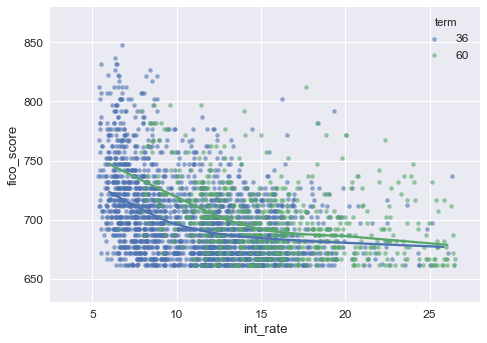

In [104]:
plot_df = df.query('fico_score > 650 & int_rate <28')[:3000]

sns.set(font_scale=1.2, rc={"lines.linewidth": 1.5}) 

g = sns.lmplot("int_rate", "fico_score", x_jitter= .7,  y_jitter= .1, data=plot_df, hue='term',lowess=True, size=5,aspect=1.4, legend_out=False, scatter_kws={ 's':20, 'alpha':.6})

g.set(xlim=(2.5, 28),ylim=(630, 880),alpha = .5)

#g.savefig('1.png',transparent=True)

short-term loans have higher "fico_score" especially at lower "int_rate". I will explore the correlations between variables in the later analysis.

### open_acc
Data Dictionary: "The number of open credit lines in the borrower's credit file."

In [105]:
df['open_acc'].describe()

count    814986.000000
mean         11.521099
std           5.325064
min           0.000000
25%           8.000000
50%          11.000000
75%          14.000000
max          90.000000
Name: open_acc, dtype: float64

In [106]:
#plt.figure(figsize=(10,3), dpi=90)
#sns.countplot(df['open_acc'], order=sorted(df['open_acc'].unique()),saturation=1)
#_, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
#plt.title('Number of Open Credit Lines')

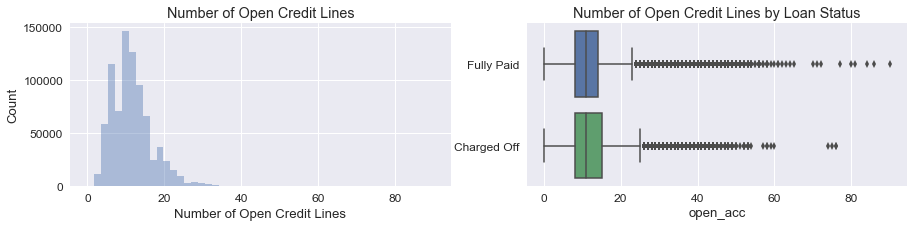

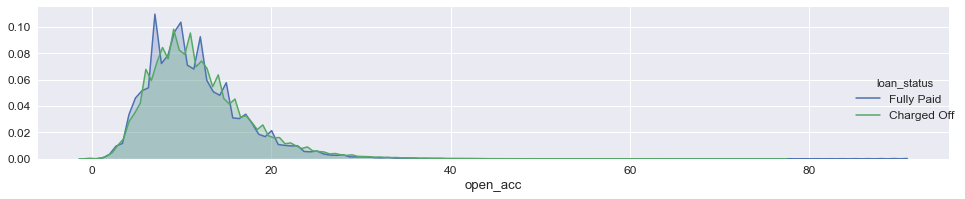

In [107]:
plot_var('open_acc', 'Number of Open Credit Lines', continuous=True)

There seems no significant difference in number of credit lines between fully paid loans and charged-off loans.

In [108]:
df.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,11.883094,5.515590,0.0,8.0,11.0,15.0,76.0
Fully Paid,646902.0,11.427041,5.270369,0.0,8.0,11.0,14.0,90.0


### pub_rec
Data Dictionary: "Number of derogatory public records."

In [109]:
df['pub_rec'].describe()

count    814986.000000
mean          0.205734
std           0.584933
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          86.000000
Name: pub_rec, dtype: float64

In [110]:
df['pub_rec'].value_counts().sort_values(ascending=False)

0.0     681509
1.0     112483
2.0      14115
3.0       4107
4.0       1400
5.0        651
6.0        338
7.0        146
8.0         90
9.0         42
10.0        28
11.0        24
12.0        15
13.0        11
15.0         5
18.0         3
16.0         2
19.0         2
14.0         2
49.0         2
28.0         2
86.0         1
34.0         1
24.0         1
46.0         1
54.0         1
63.0         1
17.0         1
21.0         1
40.0         1
Name: pub_rec, dtype: int64

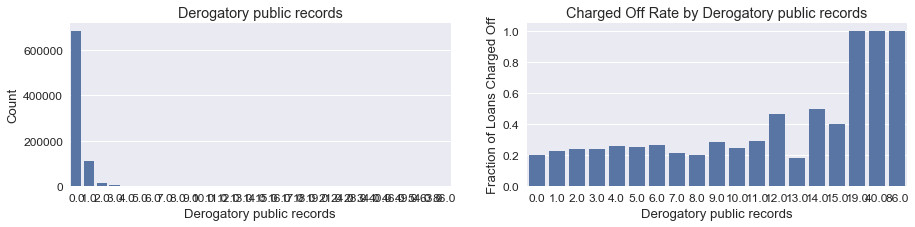

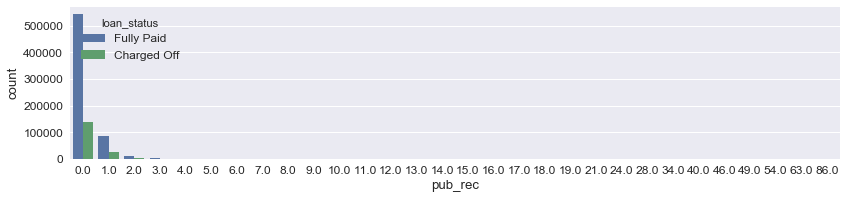

In [111]:
plot_var('pub_rec','Derogatory public records', continuous=False)

"pub_rec" > 11 have significant of Charged-Off rate. However, it's affected by low-counts. If we look at the overall statistics, the mean difference in "pub_Rec" is just 0.04 for fully paid/charged Off

In [112]:
df.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,0.232247,0.640855,0.0,0.0,0.0,0.0,86.0
Fully Paid,646902.0,0.198845,0.569304,0.0,0.0,0.0,0.0,63.0


What if we group the few bins with lower values together into 1 bin?

In [113]:
df.pub_rec = df.pub_rec.map(lambda x: 3 if x >2.0 else x)

In [114]:
df['pub_rec'].value_counts().sort_values(ascending=False)

0.0    681509
1.0    112483
2.0     14115
3.0      6879
Name: pub_rec, dtype: int64

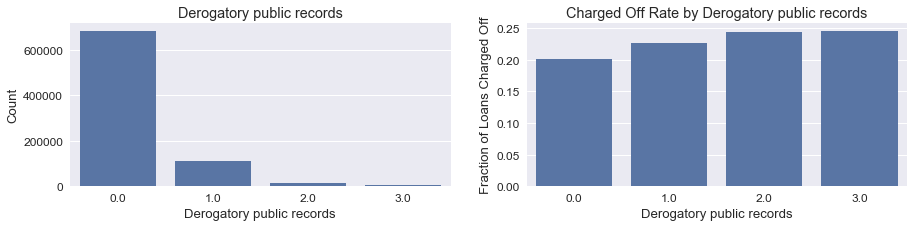

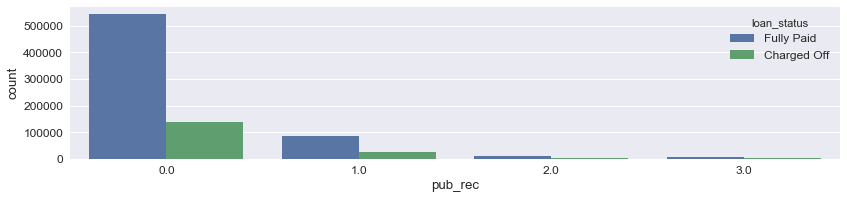

In [115]:
plot_var('pub_rec','Derogatory public records', continuous=False)

In [116]:
df.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,0.222591,0.523628,0.0,0.0,0.0,0.0,3.0
Fully Paid,646902.0,0.191584,0.485842,0.0,0.0,0.0,0.0,3.0


After grouping, it is clear that: pub_rec are mostly 0 & 1; pub_rec with 1 and higher have higher chance of being charged off than pub_rec of 0. 

### pub_rec_bankruptcies
Data Dictionary: "Number of public record bankruptcies."

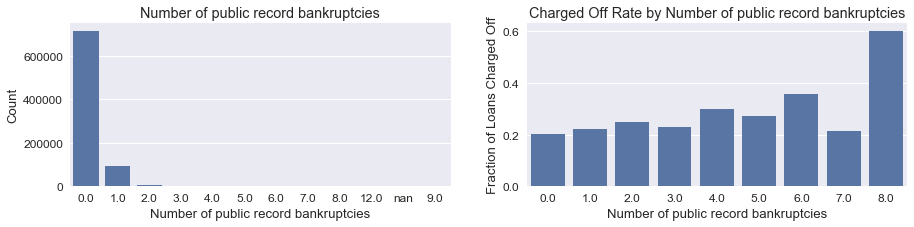

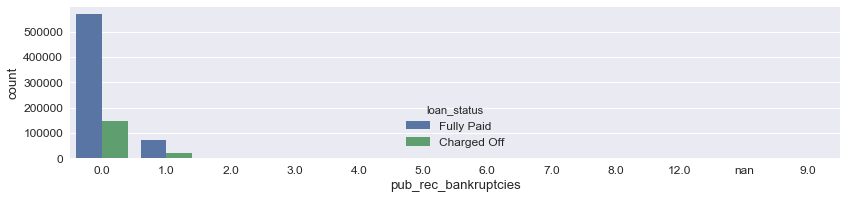

In [117]:
plot_var('pub_rec_bankruptcies', 'Number of public record bankruptcies', continuous=False)

In [118]:
df[['pub_rec','pub_rec_bankruptcies']].corr()

,pub_rec,pub_rec_bankruptcies
pub_rec,1.000000,0.750146
pub_rec_bankruptcies,0.750146,1.000000


"pub_rec" and "pub_rec_bankruptcies" are highly correlated. could only feed one of them into the modeling.

### revol_bal
Data Dictionary: "Total credit revolving balance."

In [119]:
df['revol_bal'].describe()

count    8.149860e+05
mean     1.606864e+04
std      2.160500e+04
min      0.000000e+00
25%      6.014000e+03
50%      1.118500e+04
75%      1.972300e+04
max      2.568995e+06
Name: revol_bal, dtype: float64

In [120]:
df['revol_bal'] = df['revol_bal'].apply(lambda x:np.log10(x+1))

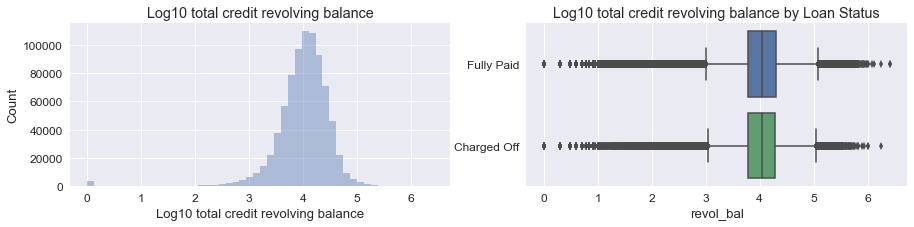

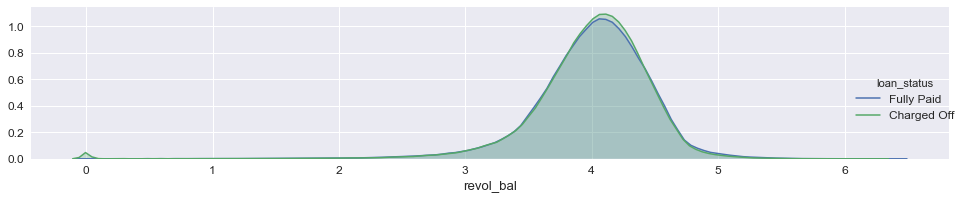

In [121]:
plot_var('revol_bal', 'Log10 total credit revolving balance', continuous=True)

### revol_util
Data Dictionary: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."

In [122]:
df['revol_util'].describe()

count    814496.000000
mean         53.031137
std          24.320981
min           0.000000
25%          35.000000
50%          53.700000
75%          71.900000
max         892.300000
Name: revol_util, dtype: float64

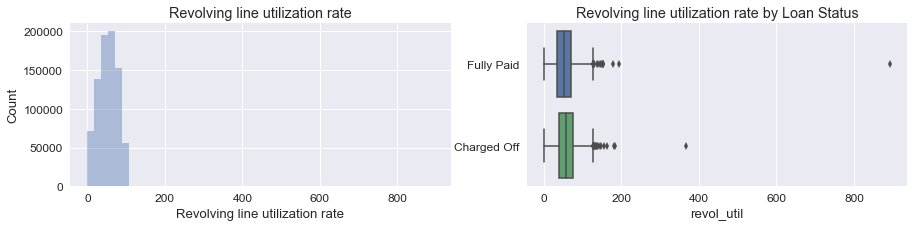

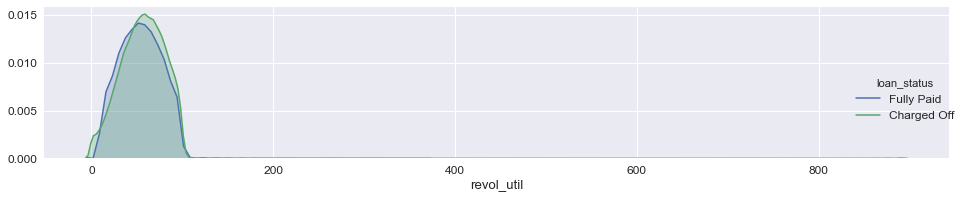

In [123]:
plot_var('revol_util', 'Revolving line utilization rate', continuous=True)

In [124]:
df.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,167974.0,56.475417,23.566253,0.0,39.5,57.5,74.7,366.6
Fully Paid,646522.0,52.136273,24.433954,0.0,33.9,52.7,71.0,892.3


Charged Off loans tend to have higher revol_util.

### total_acc
Data Dictionary: "The total number of credit lines currently in the borrower's credit file."

In [125]:
df['total_acc'].describe()

count    814986.000000
mean         25.421359
std          11.970502
min           2.000000
25%          17.000000
50%          24.000000
75%          32.000000
max         176.000000
Name: total_acc, dtype: float64

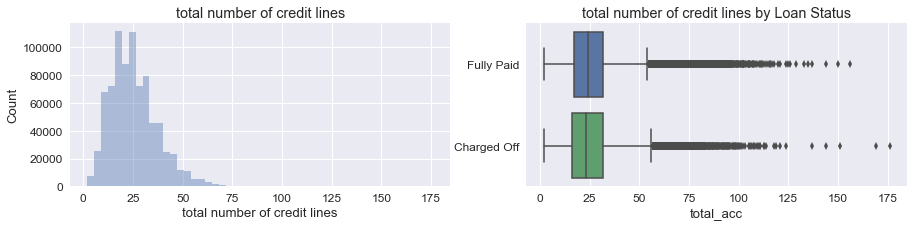

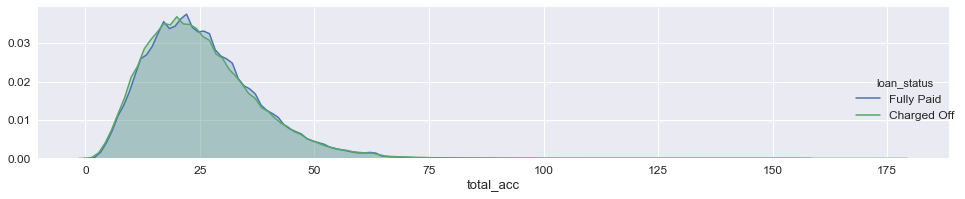

In [126]:
plot_var('total_acc', 'total number of credit lines', continuous=True)

### initial_list_status
Data Dictionary: "The initial listing status of the loan. Possible values are – W, F  (whole vs. fractional)

In [127]:
df['initial_list_status'].value_counts()

f    413678
w    401308
Name: initial_list_status, dtype: int64

Half of the granted loans are in whole amount and half are in fractional amount. "Whole" has higher fraction of Charged-Off.

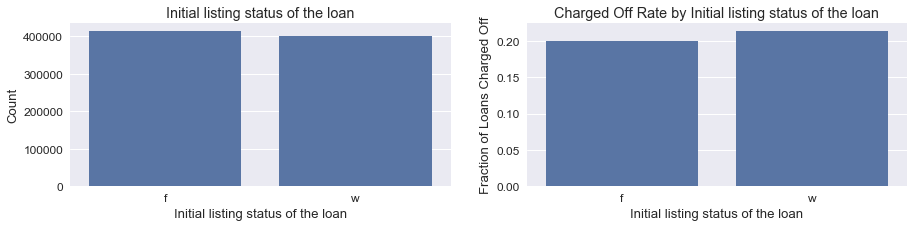

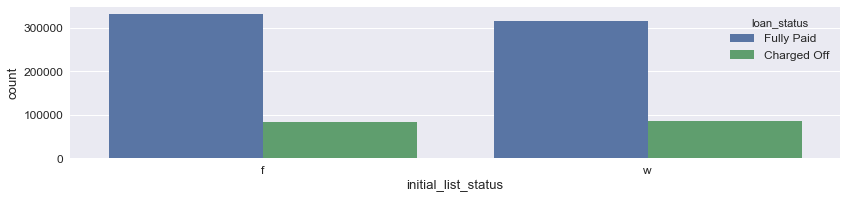

In [128]:
plot_var('initial_list_status','Initial listing status of the loan', continuous=False)

### policy_code
Data Dictionary: "publicly available policy_code=1; new products not publicly available policy_code=2"

In [129]:
df['policy_code'].value_counts()

1.0    814986
Name: policy_code, dtype: int64

All values are the same; drop this feature. 

In [130]:
drop_cols('policy_code')

### application_type
Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

In [131]:
df['application_type'].value_counts()

Individual    811207
Joint App       3779
Name: application_type, dtype: int64

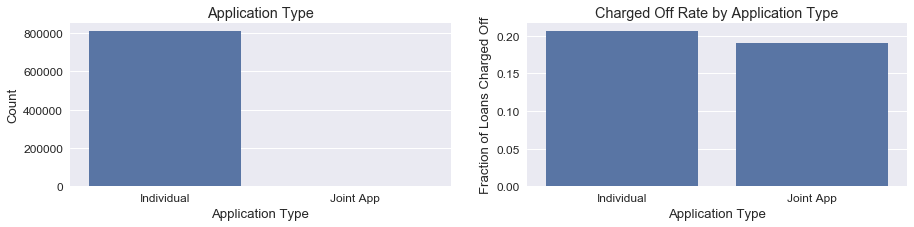

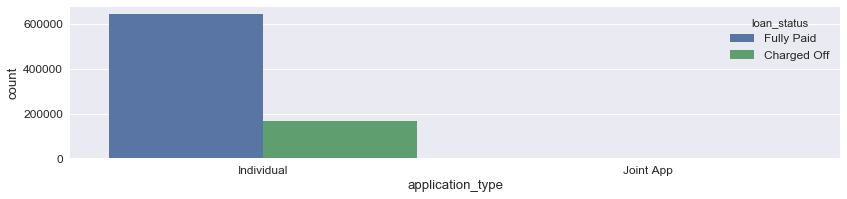

In [132]:
plot_var('application_type', 'Application Type', continuous=False)

The majority of the loans are individual applications and they are more possible to be charged off than joint app.

### mo_sin_old_il_acct
Data Dictionary: "Months since oldest bank installment account opened."

In [133]:
df['mo_sin_old_il_acct'].describe()

count    725427.000000
mean        125.926232
std          51.554620
min           0.000000
25%          98.000000
50%         129.000000
75%         152.000000
max         724.000000
Name: mo_sin_old_il_acct, dtype: float64

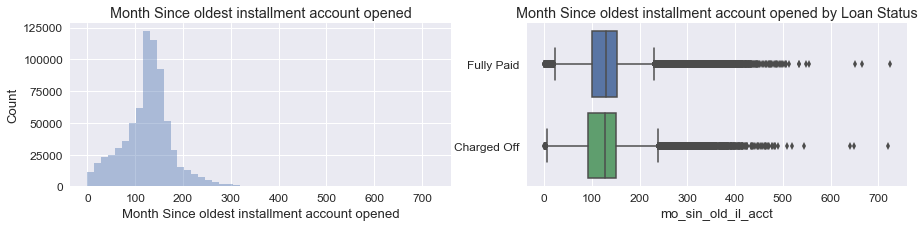

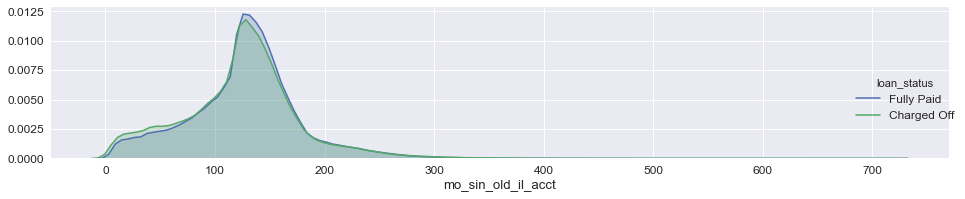

In [134]:
plot_var('mo_sin_old_il_acct', 'Month Since oldest installment account opened', continuous=True)

### mo_sin_old_rev_tl_op
Data Dictionary: "Months since oldest revolving account opened."

In [135]:
df['mo_sin_old_rev_tl_op'].describe()

count    747458.000000
mean        180.843182
std          92.192939
min           2.000000
25%         117.000000
50%         164.000000
75%         228.000000
max         842.000000
Name: mo_sin_old_rev_tl_op, dtype: float64

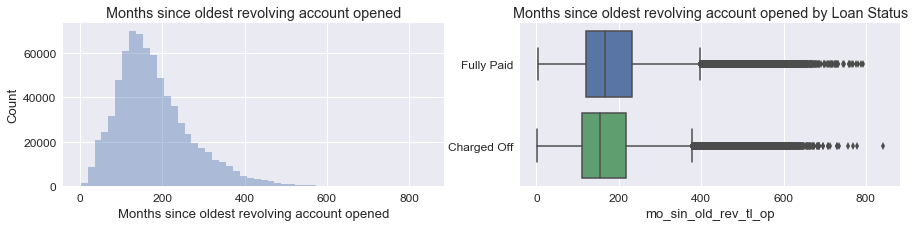

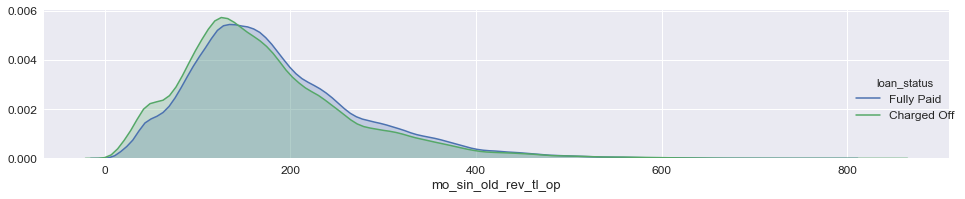

In [136]:
plot_var('mo_sin_old_rev_tl_op', 'Months since oldest revolving account opened', continuous=True)

### mort_acc
Data Dictionary: "Number of mortgage accounts."

In [137]:
df['mort_acc'].describe()

count    767705.000000
mean          1.758707
std           2.081730
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          51.000000
Name: mort_acc, dtype: float64

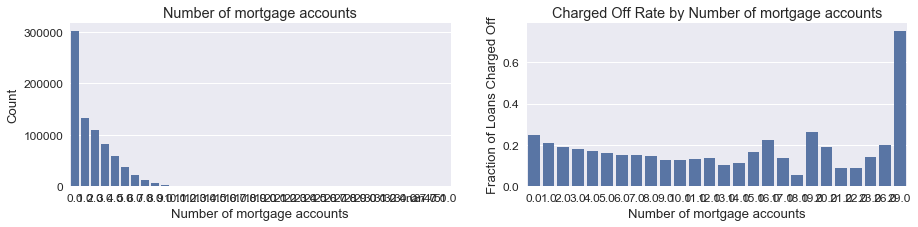

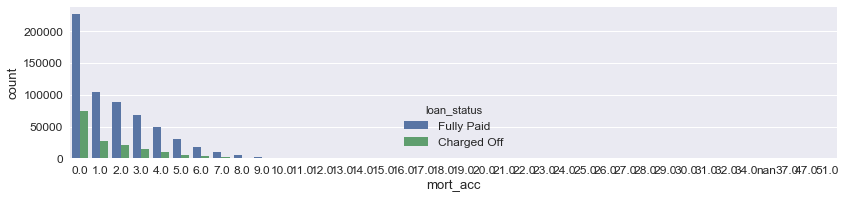

In [138]:
plot_var('mort_acc', 'Number of mortgage accounts', continuous=False)

In [139]:
df.mort_acc = df.mort_acc.map(lambda x: 6.0 if x > 6.0 else x)

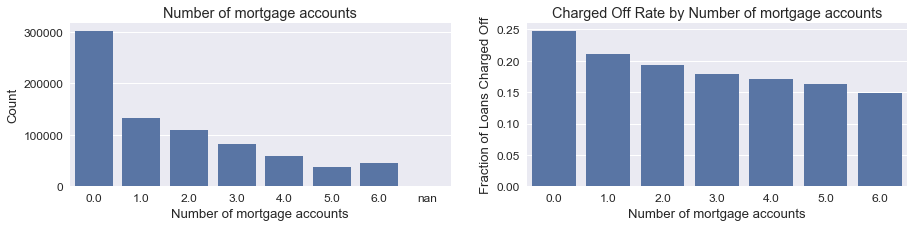

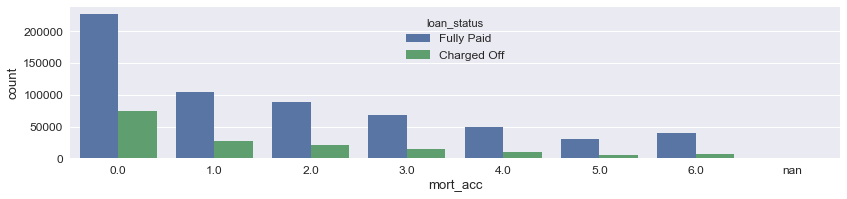

In [140]:
plot_var('mort_acc', 'Number of mortgage accounts', continuous=False)

The more the number of mortgage accounts, the lower fraction of loans charged off. 

In [141]:
df.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,161198.0,1.401177,1.737651,0.0,0.0,1.0,2.0,6.0
Fully Paid,606507.0,1.765027,1.881911,0.0,0.0,1.0,3.0,6.0


## 5 (Linear) correlation between (numerical) features 
<a id="corr"></a>
I have looked at the features individually. Now I'm going to explore the correlations between the features. 

### 5.1 Convert target variable to 0/1 indicator
<a id="converttarget"></a>
It's more convenient/useful to convert our target variable to numerical variable. Fully Paid = 0, Charged Off = 1

In [142]:
# Next, I will convert the "loan_status" column to a 0/1 "charged off" column. Fully Paid:0 Charged Off: 1
df['Charged_Off'] = df['loan_status'].apply(lambda s: np.float(s == 'Charged Off'))
drop_cols('loan_status')

### 5.2 K-S test
<a id="kstest"></a>

We can use K-S tests to check whether the distributions of each feature of the two classes ("Fully paid" or "charged-off") are drawn from the same distribution. If the K-S statistic is small or the p-value is high, we cannot reject the null hypothesis that the distributions of the two samples are the same, i.e., if p<0.05: different.

For variables with values of either 0 or 1, so we can use proportion Z tests to check whether the difference in mean values is statistically significant.

K-S Tests and Z Tests and chi-squared Tests
- We can use K-S tests to check whether the distributions of each feature of the two classes are drawn from the same distribution. 
- For features with only 0 or 1 values, we can use proportion Z tests to check whether the difference in mean values is statistically significant. 
- For categorical features, we can use chi-squared Tests

In [143]:
list_float = df.select_dtypes(exclude=['object']).columns

In [144]:
def run_KS_test(feature):
    dist1 = df.loc[df.Charged_Off == 0,feature]
    dist2 = df.loc[df.Charged_Off == 1,feature]
    print(feature+':')
    print(ks_2samp(dist1,dist2),'\n')

In [145]:
from statsmodels.stats.proportion import proportions_ztest
def run_proportion_Z_test(feature):
    dist1 = df.loc[df.Charged_Off == 0, feature]
    dist2 = df.loc[df.Charged_Off == 1, feature]
    n1 = len(dist1)
    p1 = dist1.sum()
    n2 = len(dist2)
    p2 = dist2.sum()
    z_score, p_value = proportions_ztest([p1, p2], [n1, n2])
    print(feature+':')
    print('z-score = {}; p-value = {}'.format(z_score, p_value),'\n')

In [146]:
from scipy.stats import chi2_contingency
def run_chi2_test(df, feature):

    dist1 = df.loc[df.loan_status == 'Fully Paid',feature].value_counts().sort_index().tolist()
    dist2 = df.loc[df.loan_status == 'Charged Off',feature].value_counts().sort_index().tolist()
    chi2, p, dof, expctd = chi2_contingency([dist1,dist2])
    print(feature+':')
    print("chi-square test statistic:", chi2)
    print("p-value", p, '\n')

In [147]:
#ks_list = ['loan_amnt','int_rate','installment','emp_length','annual_inc','dti','earliest_cr_line','open_acc','pub_rec','mo_sin_old_il_acct','mo_sin_old_rev_tl_op','fico_score','pub_rec_bankruptcies']

In [148]:
for i in list_float:
    run_KS_test(i)    

loan_amnt:
Ks_2sampResult(statistic=0.07929615091065739, pvalue=0.0) 

term:
Ks_2sampResult(statistic=0.1878843211069673, pvalue=0.0) 

int_rate:
Ks_2sampResult(statistic=0.25494110149394783, pvalue=0.0) 

installment:
Ks_2sampResult(statistic=0.06536048843842956, pvalue=0.0) 

emp_length:
Ks_2sampResult(statistic=0.023675009354882204, pvalue=2.0124344632383046e-65) 

annual_inc:
Ks_2sampResult(statistic=0.0820131215319414, pvalue=0.0) 

dti:
Ks_2sampResult(statistic=0.13172341350693528, pvalue=0.0) 

earliest_cr_line:
Ks_2sampResult(statistic=0.05313445396103783, pvalue=0.0) 

open_acc:
Ks_2sampResult(statistic=0.03457677956795924, pvalue=4.596625980394497e-139) 

pub_rec:
Ks_2sampResult(statistic=0.0230215607998836, pvalue=6.952780246869564e-62) 

revol_bal:
Ks_2sampResult(statistic=0.011420765232811325, pvalue=1.4985768186837867e-15) 

revol_util:
Ks_2sampResult(statistic=0.07482343533269276, pvalue=0.0) 

total_acc:
Ks_2sampResult(statistic=0.018250693539464735, pvalue=4.7375970444

OK, it seems that all of these features have different distributions for Fully Paid/Charged Off.

### 5.3 Pearson Correlation
<a id="pearson"></a>

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 814986 entries, 0 to 1646792
Data columns (total 27 columns):
loan_amnt               814986 non-null float64
term                    814986 non-null int64
int_rate                814986 non-null float64
installment             814986 non-null float64
sub_grade               814986 non-null object
emp_length              772733 non-null float64
home_ownership          814986 non-null object
annual_inc              814986 non-null float64
verification_status     814986 non-null object
issue_d                 814986 non-null object
purpose                 814986 non-null object
addr_state              814986 non-null object
dti                     814950 non-null float64
earliest_cr_line        814986 non-null float64
open_acc                814986 non-null float64
pub_rec                 814986 non-null float64
revol_bal               814986 non-null float64
revol_util              814496 non-null float64
total_acc               814986 n

In [150]:
list_float = df.select_dtypes(exclude=['object']).columns

In [151]:
list_float

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'annual_inc', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mort_acc', 'pub_rec_bankruptcies',
       'fico_score', 'Charged_Off'],
      dtype='object')

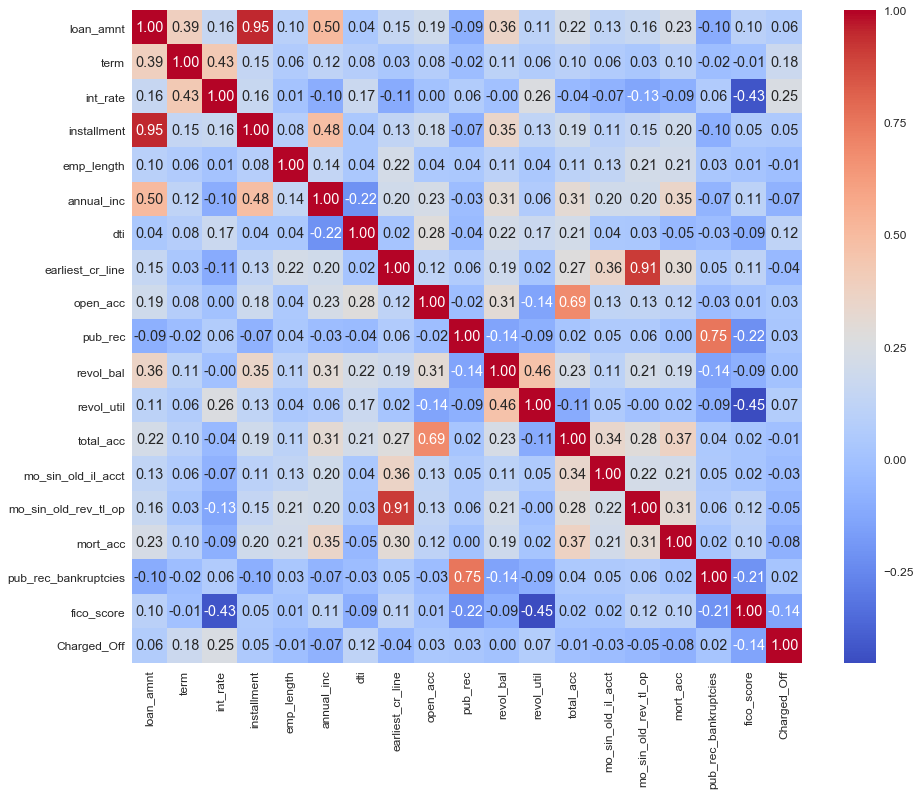

In [152]:
fig, ax = plt.subplots(figsize=(15,12))         # Sample figsize in inches
cm_df = sns.heatmap(df[list_float].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)

The linearly correlated features are: 
- "installment" vs "loan_amnt" (0.95)
- "mo_sin_old_rev_tl_op"* vs "earliest_cr_line" (0.91)
- "pub_rec_bankruptcies"* vs "pub_rec" (0.75)
- "total_acc" vs "open_acc" (0.69)   
(*) with null values

Dependence of Charged-off on the predictors: "int_rate" is the most correlated one.

In [153]:
cor = df[list_float].corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.1) | (cor < -0.1)]

term                  loan_amnt               0.386449
int_rate              loan_amnt               0.158214
                      term                    0.426839
installment           loan_amnt               0.953588
                      term                    0.145842
                      int_rate                0.160821
annual_inc            loan_amnt               0.504394
                      term                    0.122812
                      int_rate               -0.102222
                      installment             0.483259
                      emp_length              0.136435
dti                   int_rate                0.170415
                      annual_inc             -0.215161
earliest_cr_line      loan_amnt               0.148525
                      int_rate               -0.112131
                      installment             0.131444
                      emp_length              0.216412
                      annual_inc              0.202806
open_acc  

In [154]:
df[["installment","loan_amnt","mo_sin_old_rev_tl_op","earliest_cr_line","total_acc","open_acc", "pub_rec_bankruptcies", "pub_rec"]].isnull().any()

installment             False
loan_amnt               False
mo_sin_old_rev_tl_op     True
earliest_cr_line        False
total_acc               False
open_acc                False
pub_rec_bankruptcies     True
pub_rec                 False
dtype: bool

In [155]:
list_linear = ['installment', 'mo_sin_old_rev_tl_op','total_acc','pub_rec_bankruptcies']

In [156]:
linear_corr = pd.DataFrame()

In [157]:
# Pearson coefficients
for col in df[list_float].columns:
    linear_corr.loc[col, 'pearson_corr'] = df[col].corr(df['Charged_Off'])
linear_corr['abs_pearson_corr'] = abs(linear_corr['pearson_corr'])

In [158]:
# F-statistics:
    

Sort the results by the absolute value of the Pearson Correlation

In [159]:
linear_corr.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_corr.drop('abs_pearson_corr', axis=1, inplace=True)
linear_corr.drop('Charged_Off', axis=0, inplace=True)

In [160]:
linear_corr.reset_index(inplace=True)
#linear_corr.rename(columns={'index':'variable'}, inplace=True)

In [161]:
linear_corr

,index,pearson_corr
0,int_rate,0.247815
1,term,0.177708
2,fico_score,-0.139429
3,dti,0.123031
4,mort_acc,-0.079739
5,annual_inc,-0.074216
6,revol_util,0.072185
7,loan_amnt,0.064139
8,mo_sin_old_rev_tl_op,-0.048529
9,installment,0.046291


The variables most linearly correlated with our target variable are interest rate, loan term, Fico Score and debt-to-income ratio. The least correlated features are the revolving balance, employment length, and public record. 

In [162]:
# Drop the linear correlated features
drop_cols(list_linear)

In [163]:
df.shape

(814986, 23)

## 6. Feature Engineering
<a id="featureeng"></a>
I am going to further cleaning the data. 

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 814986 entries, 0 to 1646792
Data columns (total 23 columns):
loan_amnt              814986 non-null float64
term                   814986 non-null int64
int_rate               814986 non-null float64
sub_grade              814986 non-null object
emp_length             772733 non-null float64
home_ownership         814986 non-null object
annual_inc             814986 non-null float64
verification_status    814986 non-null object
issue_d                814986 non-null object
purpose                814986 non-null object
addr_state             814986 non-null object
dti                    814950 non-null float64
earliest_cr_line       814986 non-null float64
open_acc               814986 non-null float64
pub_rec                814986 non-null float64
revol_bal              814986 non-null float64
revol_util             814496 non-null float64
initial_list_status    814986 non-null object
application_type       814986 non-null object
mo_si

In [165]:
df.sample(5)

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,initial_list_status,application_type,mo_sin_old_il_acct,mort_acc,fico_score,Charged_Off
1183776,8000.0,36,15.59,C5,1.0,OWN,4.732402,Source Verified,Jul-2016,other,IN,23.38,32.208219,11.0,1.0,4.463012,60.8,f,Individual,283.0,3.0,667.0,1.0
1363690,16000.0,60,14.46,C4,10.0,MORTGAGE,4.845104,Verified,May-2016,debt_consolidation,FL,19.42,11.690411,10.0,0.0,4.023047,45.8,w,Individual,53.0,1.0,672.0,0.0
967274,16200.0,36,14.33,C1,3.0,MORTGAGE,4.647393,Not Verified,Aug-2012,credit_card,FL,24.51,14.693151,14.0,0.0,4.183981,83.5,f,Individual,NaN,1.0,682.0,0.0
215224,10000.0,36,9.67,B1,NaN,OWN,4.698979,Source Verified,Feb-2014,debt_consolidation,TX,11.71,14.945205,4.0,1.0,3.387212,58.0,f,Individual,126.0,0.0,687.0,0.0
401568,17500.0,60,11.53,B5,8.0,MORTGAGE,4.792399,Not Verified,Oct-2015,debt_consolidation,TX,28.67,20.780822,16.0,0.0,4.203821,58.4,w,Individual,153.0,3.0,702.0,0.0


In [166]:
missing_values_table(df)

Your selected dataframe has 23 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values,type
mo_sin_old_il_acct,89559,11.0,float64
mort_acc,47281,5.8,float64
emp_length,42253,5.2,float64
revol_util,490,0.1,float64
dti,36,0.0,float64


There are 5 variables with missing values (with very small percentage). They are not categorical variables. 

In [167]:
#pandas_profiling.ProfileReport(df)

### 6.1 Categorical Variables
<a id="dummies"></a>

In [168]:
dummy_list =['sub_grade','home_ownership','verification_status','purpose','addr_state','initial_list_status','application_type']

In [169]:
df[dummy_list].isnull().any()

sub_grade              False
home_ownership         False
verification_status    False
purpose                False
addr_state             False
initial_list_status    False
application_type       False
dtype: bool

In [170]:
df = pd.get_dummies(df, columns=dummy_list, drop_first=True)

In [171]:
df.shape

(814986, 120)

In [172]:
df.head(1)

,loan_amnt,term,int_rate,emp_length,annual_inc,issue_d,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,mo_sin_old_il_acct,mort_acc,fico_score,Charged_Off,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
0,15000.0,60,12.39,10.0,4.8921,Dec-2014,12.03,23.950685,6.0,0.0,5.139907,29.0,103.0,0.0,752.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


Looks good. all data are numerical, except "issue_d", which we will use to split test/train sample and then it will be dropped. 

### 6.2 Train/Test data split
<a id="split"></a>

We will use loans funded on earlier dates to predict the outcome of loans funded on later dates

We use "issue_d". 

In [173]:
df['issue_d'].sample()

927199    Feb-2013
Name: issue_d, dtype: object

In [174]:
df['issue_d'].isnull().any()

False

"issue_d" has month and year, no null values.

In [175]:
df['issue_d'] = pd.to_datetime(df['issue_d'])

In [176]:
df['issue_d'].sample()

1147820   2016-08-01
Name: issue_d, dtype: datetime64[ns]

In [177]:
df['issue_d'].describe()

count                  814986
unique                    124
top       2014-10-01 00:00:00
freq                    33699
first     2007-06-01 00:00:00
last      2017-09-01 00:00:00
Name: issue_d, dtype: object

There are 124 unique values. The first loans were issued in Jan 2007 and the last loans were issued in September 2017. The busiest month was Oct 2014, with 33699 loans funded in that month. Let's further check the distribution of loans funded per month.

Text(0.5,1,'Loans funded per Year')

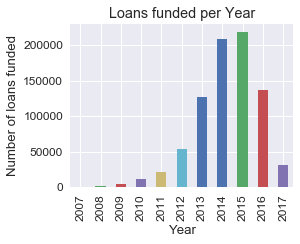

In [178]:
plt.figure(figsize=(4,3))
df['issue_d'].dt.year.value_counts().sort_index().plot.bar()
plt.xlabel('Year')
plt.ylabel('Number of loans funded')
plt.title('Loans funded per Year')

Interestingly, the funded loans significantly increased since 2013, and continued through 2015. What did LendingCLub do in year 2012? 

We will split the train/test sample at 8:2. 

In [179]:
df_train = df.loc[df['issue_d']  < df['issue_d'].quantile(0.8)]
df_test =  df.loc[df['issue_d'] >= df['issue_d'].quantile(0.8)]

In [180]:
print('Number of loans in the partition:   ', df_train.shape[0] + df_test.shape[0])
print('Number of loans in the full dataset:', df.shape[0])

Number of loans in the partition:    814986
Number of loans in the full dataset: 814986


Let's look at the summary statistics of the issue dates in the train/test sets.

In [181]:
df_train['issue_d'].describe()

count                  647071
unique                    103
top       2014-10-01 00:00:00
freq                    33699
first     2007-06-01 00:00:00
last      2015-12-01 00:00:00
Name: issue_d, dtype: object

In [182]:
df_test['issue_d'].describe()

count                  167915
unique                     21
top       2016-03-01 00:00:00
freq                    22914
first     2016-01-01 00:00:00
last      2017-09-01 00:00:00
Name: issue_d, dtype: object

Now we can delete the "issue_d"

In [183]:
df_train.drop('issue_d', axis=1, inplace=True)
df_test.drop('issue_d', axis=1, inplace=True)

Now separate the predictor variables from the target variable

In [184]:
X_train = df_train.drop(['Charged_Off'], axis=1)
y_train = df_train.loc[:, 'Charged_Off']

X_test = df_test.drop(['Charged_Off'], axis=1)
y_test = df_test['Charged_Off']

### 6.3 Imputing missing values
<a id="imputing"></a>   

In [185]:
#missing_values_table(df)

We will create an imputer object with the strategy set to median. We then train this object on the **training** data and uset it to fill in the missing values in **both** the training and testing data. This means that missing values in the *test* data are filled in with the corresponding median value from the *training* data. We do it this way to avoid the problem of test data leakage. 

In [186]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [187]:
missing_values_table(X_train)

Your selected dataframe has 118 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,type


In [188]:
missing_values_table(X_test)

Your selected dataframe has 118 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,type


### 6.4 Feature Scaling
<a id="scaling"></a>  


As features are measured in different units, they cover different ranges. Some ML models, such as SVM, KNN that take into account distance measures between observations are therefore significantly affected by the range of the features and scaling allows them to learn. While some methods, such as Linear Regression and Ransom Forest do not actually require feature scaling, it's still best practice to take this step when we are comparing multiple algorithms. 

Removing mean and dividing the standard deviation of features respectively. 

In [189]:
from sklearn.preprocessing import StandardScaler

In [190]:
# Create an imputer object with a median filling strategy
scaler = StandardScaler()

# Train on the training features
scaler.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [191]:
#X_train.describe()

In [192]:
#X_test.describe()

In [193]:
# The dataframe is ready to be represented as matrix that is amemnable to sklearn. 

#X_train = X_train.values
#y_train = y_train.values
#X_test = X_test.values
#y_test = y_test.values

In [194]:
y_test.isnull().any()

False

### 6.5 PCA visualization of the train data
<a id="pca"></a>  

I'm going to do a PCA analysis to check whether we can find the combinations of variables that explain the most variance.

I will use a 2D PCA projection to visualize the entire dataset. I will plot different classes using different colors and check whether the classes are well-separated from each other.

In [195]:
#X_train.dtypes

In [196]:
#X_train.describe()

In [197]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train.values)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [198]:
principalDf.head(5)

,principal component 1,principal component 2
0,0.393198,-0.613313
1,-1.597995,-2.654595
2,0.643542,1.156932
3,-0.557668,1.884947
4,0.164550,0.517976


In [199]:
y_train_df = pd.DataFrame(data=y_train.values, columns=['Charged_Off'])

In [200]:
finalDf = pd.concat([principalDf, y_train_df], axis = 1)
finalDf.head(5)

,principal component 1,principal component 2,Charged_Off
0,0.393198,-0.613313,0.0
1,-1.597995,-2.654595,1.0
2,0.643542,1.156932,0.0
3,-0.557668,1.884947,1.0
4,0.164550,0.517976,0.0


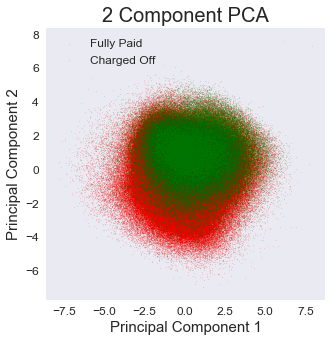

In [201]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Charged_Off'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 1, alpha=0.1)
ax.legend(['Fully Paid', 'Charged Off'])
ax.grid()

In [202]:
pca.explained_variance_ratio_

array([0.02560504, 0.02453587])

The two classes appear to be not separated at all. 
The explained variance tells us how much information (variance) can be attributed to each of the principal components (0.03)

### 6.6 Linear dependence of Charged-Off
<a id="pearson2"></a>  


In [203]:
linear_corr = pd.DataFrame()

In [204]:
# Pearson coefficients
for col in X_train.columns:
    linear_corr.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_corr['abs_pearson_corr'] = abs(linear_corr['pearson_corr'])

Sort the results by the absolute value of the Pearson Correlation

In [205]:
linear_corr.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_corr.drop('abs_pearson_corr', axis=1, inplace=True)

In [206]:
linear_corr.reset_index(inplace=True)
#linear_corr.rename(columns={'index':'variable'}, inplace=True)

In [207]:
linear_corr.head(10)

,index,pearson_corr
0,verification_status_Verified,0.010210
1,revol_bal,0.009671
2,revol_util,0.008250
3,purpose_debt_consolidation,0.007217
4,initial_list_status_w,-0.006592
5,dti,0.006510
6,loan_amnt,0.006261
7,int_rate,0.006168
8,addr_state_NV,0.004709
9,fico_score,-0.004639


In [208]:
linear_corr.tail(10)

,index,pearson_corr
108,addr_state_DE,-0.000282
109,addr_state_SC,0.000264
110,addr_state_RI,-0.000147
111,addr_state_MO,0.000137
112,addr_state_CA,0.000117
113,sub_grade_G1,0.000106
114,addr_state_OH,0.000071
115,sub_grade_D5,0.000049
116,addr_state_LA,-0.000012
117,addr_state_SD,-0.000009


In [209]:
""" 
<!--- 
## 7. Modeling 
<a id="modeling"></a>
We will compare 10 of the most popular classifiers and evaluate their performance using a stratified kfold cross validation procedure.  ML models using the Scikit-Learn library:
1. SGD Logistic Regression
2. Linear Discriminant Analysis
3. SVC
4. KNN
5. Random Forest (RFC)
6. Decision Tree
7. Extra Trees (ExtC)
8. AdaBoost (Ada)
9. Gradient Boosting (GBC)
10. Multiple layer perceptron (neural network)

*I am using Stratified K Fold because there the classes are unbalanced. I do not want any folds to have only 1 particular class or even 1 class dominating the other one as it may create a bias in that particular fold. Stratification makes sure that the percentage of samples for each class is similar across folds(if not same).

--->
"""

' \n<!--- \n## 7. Modeling \n<a id="modeling"></a>\nWe will compare 10 of the most popular classifiers and evaluate their performance using a stratified kfold cross validation procedure.  ML models using the Scikit-Learn library:\n1. SGD Logistic Regression\n2. Linear Discriminant Analysis\n3. SVC\n4. KNN\n5. Random Forest (RFC)\n6. Decision Tree\n7. Extra Trees (ExtC)\n8. AdaBoost (Ada)\n9. Gradient Boosting (GBC)\n10. Multiple layer perceptron (neural network)\n\n*I am using Stratified K Fold because there the classes are unbalanced. I do not want any folds to have only 1 particular class or even 1 class dominating the other one as it may create a bias in that particular fold. Stratification makes sure that the percentage of samples for each class is similar across folds(if not same).\n\n--->\n'

## 7. Modeling 
<a id="modeling"></a>

- I will implement the ML pipeline with Dimension reduction and the chosen model.
- The following models are evaluated, with stratified kfold cross validation procedure*. 
    - Logistic regression with SGD training
    - Random Forest
    - KNN
- Metrics: F1 score, confusion matrices, AUROC
As we have an unbalanced dataset problem and we care accuracy of one class over other(false-positives (loans that are fully paid but are predicted to be charged off) are not so bad definitely do not want any false negatives (predicted to be fully paid but eventually charged off)), we could display the class accuracies in confusion matrices.

*I am using Stratified K Fold because there the classes are unbalanced. I do not want any folds to have only 1 particular class or even 1 class dominating the other one as it may create a bias in that particular fold. Stratification makes sure that the percentage of samples for each class is similar across folds(if not same).


In [210]:
# CV model with Kfold stratified cross val
kfold = 3
random_state = 42

### 7.1 Logistic Regression with SGD
<a id="logreg"></a>
logistic regression with stochastic gradient descent training.

In [211]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

In [212]:
pipeline_sgdlr = Pipeline([
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=random_state, warm_start=True))
])

A small grid of hyper parameters to search over

In [213]:
param_grid_sgdlr  = {
    'model__alpha': [10**-5, 10**-1, 10**2],
    'model__penalty': ['l1', 'l2']
}

search grid objects

In [214]:
grid_sgdlr = GridSearchCV(estimator=pipeline_sgdlr, param_grid=param_grid_sgdlr, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=kfold, verbose=1, return_train_score=False)

Grid search and train the final model on the whole dataset

In [215]:
grid_sgdlr.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   51.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'model__alpha': [1e-05, 0.1, 100], 'model__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model

In [216]:
#pd.DataFrame(grid_sgdlr.cv_results_)

In [217]:
sgdlr_estimator = grid_sgdlr.best_estimator_
print('Best score: ', grid_sgdlr.best_score_)
print('Best parameters set: \n', grid_sgdlr.best_params_)

Best score:  0.7036303538280251
Best parameters set: 
 {'model__alpha': 0.1, 'model__penalty': 'l2'}


### 7.2 Random Forest
<a id="rf"></a>

In [218]:
from sklearn.ensemble import RandomForestClassifier

In [219]:
rf = RandomForestClassifier(n_jobs=-1, random_state=random_state, max_features= 'sqrt' ,n_estimators=50) 
param_grid_rf = {
    'n_estimators': [50], # The number of randomized trees to build 
    'class_weight': [{0:1, 1:1}] #'model__class_weight': [{0:1, 1:1}, {0:1,1:2}, {0:1, 1:3}, {0:1, 1:4}]
   # 'model__max_features': range(2,7),
   # 'model__min_samples_leaf':range(2,6),
}

In [220]:
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='roc_auc',n_jobs=-1,pre_dispatch='2*n_jobs', cv=kfold, verbose=1, return_train_score=False)

In [221]:
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50], 'class_weight': [{0: 1, 1: 1}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

In [222]:
rf_estimator = grid_rf.best_estimator_
print('Best score: ', grid_rf.best_score_)
print('Best parameters set: \n', grid_rf.best_params_)

Best score:  0.6512543099169019
Best parameters set: 
 {'class_weight': {0: 1, 1: 1}, 'n_estimators': 50}


Not as good as SDG Logistic regression. 
Let's check the feature importance. 

### Feature importance

In [223]:
names = list(X_train)

In [224]:
# print(sorted(zip(map(lambda x: round(x, 4), grid_rf.best_estimator_.feature_importances_), names), reverse=True))

In [225]:
#from tabulate import tabulate
#headers = ["name", "score"]
#values = sorted(zip(X_train.columns, grid_rf.best_estimator_.feature_importances_), key=lambda x:x[1] * -1)
#print(tabulate(values, headers, tablefmt="plain"))


In [226]:
feature_importances = pd.DataFrame(grid_rf.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',                                                                  ascending=False)

In [227]:
print("Features sorted by their score: Top 10")
feature_importances.head(10)

Features sorted by their score: Top 10


,importance
dti,0.075526
int_rate,0.073018
revol_bal,0.067988
revol_util,0.067137
earliest_cr_line,0.066670
annual_inc,0.065163
mo_sin_old_il_acct,0.062721
loan_amnt,0.060122
open_acc,0.050227
fico_score,0.047669


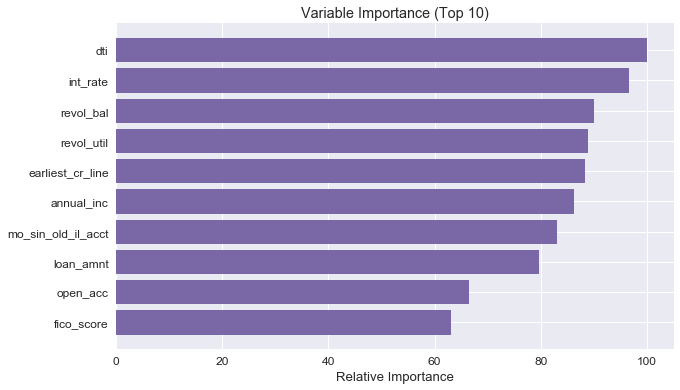

In [228]:
# Normalize The Features and visulize the top 10 features
feature_importance = 100.0 * (grid_rf.best_estimator_.feature_importances_ / grid_rf.best_estimator_.feature_importances_.max())
sorted_idx = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i])[-10:]
pos = np.arange(len(sorted_idx)) + .5
plt.figure(figsize=(10, 6))

plt.barh(pos, feature_importance[sorted_idx], align='center', color='#7A68A6')
plt.yticks(pos, np.asanyarray(X_train.columns.tolist())[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance (Top 10)')
plt.show()

In [229]:
print("Features sorted by their score: Bottom 10")
feature_importances.tail(10)

Features sorted by their score: Bottom 10


,importance
purpose_renewable_energy,0.000230
sub_grade_G4,0.000201
sub_grade_G5,0.000164
addr_state_ND,0.000130
purpose_educational,0.000117
application_type_Joint App,0.000113
home_ownership_OTHER,0.000106
addr_state_ME,0.000086
addr_state_ID,0.000005
addr_state_IA,0.000003


### Visualizing a Single Decision Tree

In [230]:
grid_rf.best_estimator_[1]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=1273642419, splitter='best')

In [231]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
rf_big = RandomForestClassifier(n_jobs=-1, random_state=random_state, n_estimators=10, max_depth=6) 
rf_big.fit(X_train, y_train)

# Pull out one tree from the forest
tree_big = rf_big.estimators_[5]
# Export the image to a dot file
export_graphviz(tree_big, out_file = '../output/big_tree.dot', feature_names = names, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('../output/big_tree.dot')
# Write graph to a png file
graph.write_png('big_tree.png')

<img src="big_tree.png">

In [232]:
# Limit depth of tree to 3 levels
rf_small = RandomForestClassifier(n_jobs=-1, random_state=random_state, n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = '../output/small_tree.dot', feature_names = names, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('../output/small_tree.dot')
graph.write_png('small_tree.png')

<img src="small_tree.png">

### 7.3 KNN 
<a id="knn"></a>

I need to reduce the number of the features for KNN (<10) for better performance [(reference at wikipedia)](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Dimension_reduction)

I will use LDA/PCA for dimension reduction (-> LDA performs faster)

In [233]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from sklearn import decomposition

In [234]:
#chaining a PCA and a knn
pipeline_knn = Pipeline([
    ('pca', decomposition.PCA()),
    ('model', KNeighborsClassifier(n_jobs=-1))   
])

pipeline_knn2 = Pipeline([
    ('lda', LinearDiscriminantAnalysis()),
    ('model', KNeighborsClassifier(n_jobs=-1))   
])


In [235]:
param_grid_knn = {
    'pca__n_components': [3,9],
    'model__n_neighbors': [5, 25, 125]
}
param_grid_knn2 = {
    'lda__n_components': [3,9],
    'model__n_neighbors': [5, 25, 125]
}

In [236]:
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=kfold, verbose=1, return_train_score=False)
grid_knn2 = GridSearchCV(estimator=pipeline_knn2, param_grid=param_grid_knn2, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=kfold, verbose=1, return_train_score=False)

In [237]:
%%time
#grid_knn.fit(X_train, y_train) # very slow

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


In [238]:
%%time
grid_knn2.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.5min finished


CPU times: user 29.5 s, sys: 9.12 s, total: 38.6 s
Wall time: 2min 39s


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)), ('model', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'lda__n_components': [3, 9], 'model__n_neighbors': [5, 25, 125]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

In [239]:
"""
knn_estimator = grid_knn.best_estimator_
print('Best score: ', grid_knn.best_score_)
print('Best parameters set: \n', grid_knn.best_params_)
"""

"\nknn_estimator = grid_knn.best_estimator_\nprint('Best score: ', grid_knn.best_score_)\nprint('Best parameters set: \n', grid_knn.best_params_)\n"

In [240]:
knn_estimator2 = grid_knn2.best_estimator_
print('Best score: ', grid_knn2.best_score_)
print('Best parameters set: \n', grid_knn2.best_params_)

Best score:  0.695501256557471
Best parameters set: 
 {'lda__n_components': 3, 'model__n_neighbors': 125}


Only 3 LDA components are necessary for kNN to perform almost as well as logistic regression. 

In [241]:
"""
# Plot the PCA spectrum
pca.fit(X_train)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [20, 40, 64]
Cs = np.logspace(-4, 4, 3)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_train, y_train)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()
"""

"\n# Plot the PCA spectrum\npca.fit(X_train)\n\nplt.figure(1, figsize=(4, 3))\nplt.clf()\nplt.axes([.2, .2, .7, .7])\nplt.plot(pca.explained_variance_, linewidth=2)\nplt.axis('tight')\nplt.xlabel('n_components')\nplt.ylabel('explained_variance_')\n\n# Prediction\nn_components = [20, 40, 64]\nCs = np.logspace(-4, 4, 3)\n\n# Parameters of pipelines can be set using ‘__’ separated parameter names:\nestimator = GridSearchCV(pipe,\n                         dict(pca__n_components=n_components,\n                              logistic__C=Cs))\nestimator.fit(X_train, y_train)\n\nplt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,\n            linestyle=':', label='n_components chosen')\nplt.legend(prop=dict(size=12))\nplt.show()\n"

### 7.4 Hyperparameter tuning on the best model
<a id="hyper"></a>

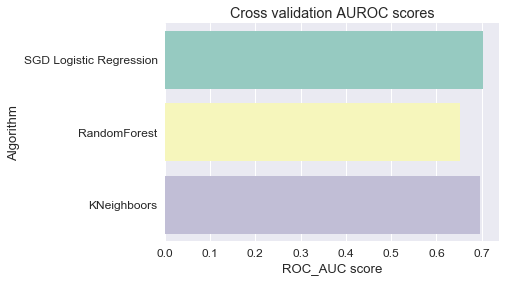

In [242]:
# plot the AUROC scores
auroc_means = [grid_sgdlr.best_score_, grid_rf.best_score_,grid_knn2.best_score_]
auroc_res = pd.DataFrame({"AUROC":auroc_means,"Algorithm":["SGD Logistic Regression",
"RandomForest","KNeighboors"]})

g = sns.barplot("AUROC","Algorithm", data = auroc_res, palette="Set3",orient = "h")
g.set_xlabel("ROC_AUC score")
g = g.set_title("Cross validation AUROC scores")


Logistic Regression provides the best results on the training data and it runs much faster than the other two models as well. Therefore, I will tun the hyperparameters of the logistic regression model

In [243]:
pipeline_sgdlr_hyper = Pipeline([
    ('model', SGDClassifier(loss='log', max_iter=2000, tol=1e-3, random_state=random_state, warm_start=True))
])

In [244]:
param_grid_sgdlr_hyper  = {
    'model__alpha': [10**-5, 10**-3, 10**2],
    'model__penalty': ['l1', 'l2']
}

In [245]:
grid_sgdlr_hyper = GridSearchCV(estimator=pipeline_sgdlr_hyper, param_grid=param_grid_sgdlr_hyper, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [246]:
result = grid_sgdlr_hyper.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.1min finished


In [247]:
sgdlr_estimator_hyper = grid_sgdlr_hyper.best_estimator_
print('Best score: ', grid_sgdlr_hyper.best_score_)
print('Best parameters set: \n', grid_sgdlr_hyper.best_params_)

Best score:  0.7094119185344374
Best parameters set: 
 {'model__alpha': 0.001, 'model__penalty': 'l2'}


### 7.5 Test set evaluation 
<a id="evaluate"></a>

In [248]:
from sklearn.metrics import roc_auc_score

In [249]:
y_pred = grid_sgdlr_hyper.best_estimator_.predict(X_test)
y_prob = grid_sgdlr_hyper.best_estimator_.predict_proba(X_test)[:,1]

In [250]:
score = roc_auc_score(y_test, y_prob)

In [251]:
matrix = metrics.confusion_matrix(y_test, y_pred)

In [252]:
print('Logistic Regression roc_auc score:', (score))

Logistic Regression roc_auc score: 0.6966159054025697


In [253]:
print('Logistic Regression:\n {}\n'.format(metrics.classification_report(y_test, y_pred)))

Logistic Regression:
              precision    recall  f1-score   support

        0.0       0.79      0.99      0.88    130718
        1.0       0.56      0.06      0.10     37197

avg / total       0.74      0.78      0.70    167915




In [254]:
print('Logistic Regression matrix:\n{}\n'.format(matrix))

Logistic Regression matrix:
[[129098   1620]
 [ 35100   2097]]



### 9. Conclusion
<a id="conclusion"></a>

I applied ML to predict the probability that a requested loan on LendingCLub will be charged off. After training with 3 models (Logistic Regression, random forest and KNN), I found that the logistic regression classifier performs the best (highest AUROC score of 0.7036) and the score on the testing dataset is slightly lower at 0.6966. 

According to the Pearson correlation between the features and the target variable, the most important features for prediction Charged-off are: interest rate, term, debt-to-income ration, and FICO score.